In [ ]:
! sudo apt-get update
! sudo apt-get install texlive-latex-recommended
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended
# ! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip
# ! unzip type1cm.zip -d /tmp/type1cm
# ! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
# ! sudo mkdir /usr/share/texmf/tex/latex/type1cm
# ! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm
! sudo texhash
!apt install cm-super

In [ ]:
# !cat /proc/cpuinfo

In [ ]:
# !nvidia-smi

In [ ]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/HPDC22")

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
from torch.autograd import Variable
from torch.optim import *

import copy
from sklearn import preprocessing

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 2

import seaborn as sns
sns.set_style("whitegrid")

current_palette = sns.color_palette("deep")

fontsize=25

## Correlation among targets

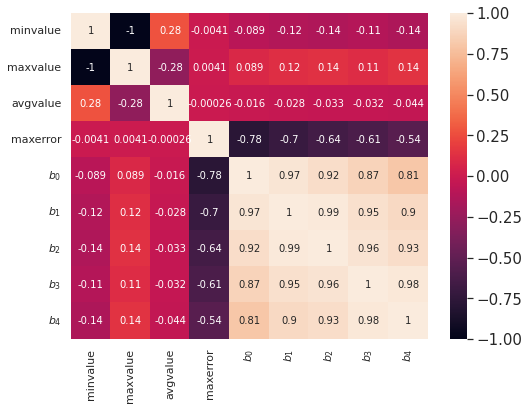

In [ ]:
# correlation among targets
for re in [512]:
    for var in ["Ex"]:
        df_features = pd.read_csv("mgard_WarpX_laser{}_{}_0_40.csv".format(re, var))
        df_data_target  = df_features[["minvalue", "maxvalue", "avgvalue", "maxerror","bp_0", "bp_1", "bp_2", "bp_3", "bp_4"]].copy()
        # df_data_target  = df_features[["bp_0", "bp_1", "bp_2", "bp_3", "bp_4"]].copy()

        # Increase the size of the heatmap.
        plt.figure(figsize=(8, 6))
        # Store heatmap object in a variable to easily access it when you want to include more features (such as title).
        # Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.

        ticklabels = ["minvalue", "maxvalue", "avgvalue", "maxerror", r"$b_0$", r"$b_1$", r"$b_2$", r"$b_3$", r"$b_4$"]
        # ticklabels = [r"$b_0$", r"$b_1$", r"$b_2$", r"$b_3$", r"$b_4$"]
        heatmap = sns.heatmap(df_data_target.corr(), vmin=-1, vmax=1, annot=True, annot_kws={"size":10}, yticklabels=ticklabels, xticklabels=ticklabels)
        # Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
        # heatmap.set_xticklabels(ticklabels, rotation=0, fontsize=15)
        # heatmap.set_yticklabels(ticklabels, rotation=0, fontsize=15)
        sns.set(font_scale=1)
        cbar = heatmap.collections[0].colorbar
        cbar.ax.tick_params(labelsize=15)

        # plt.savefig("corr.pdf", bbox_inches="tight")

## IO breakdown

In [ ]:
# def io_eval(appname, dim, varname, start, end, net):
os.chdir("/content/drive/MyDrive/Colab Notebooks/HPDC22/expr_20220310")
dname = "mgard_WarpX_beam512_Bx_0_40.csv"

df_features = pd.read_csv(dname)

def io_cost(target, level_size):
    """
    return the io cost for a single time step.

    target: [1, 5] five levels
    predict: [1, 5] five levels
    level_size: [5, 34] five levels, 32 bit planes

    """
    cost_target = []
    for level in [0, 1, 2, 3, 4]:
        cost_target_ = 0
        for bpinx in np.arange(target[level]):
            cost_target_ += level_size[level_size[1] == "level_{}".format(level)][bpinx+2].values[0]

        cost_target.append(cost_target_)
    return cost_target

for timestep in np.arange(4, 5):
    idx_l = timestep*81
    idx_r = timestep*81+81

    level_dname = "level_size/{}".format(dname)
    df = pd.read_csv(level_dname, sep=",", header=None)
    level_size = df[df[0] == "timestep_{}00".format(timestep)]

    # print(len(target), len(prediction))
    cost_target_ = []

    num_err = 81
    for errstep in np.arange(0, num_err):
        target = df_features[["bp_0", "bp_1", "bp_2", "bp_3", "bp_4"]].values[idx_l: idx_r][errstep]
        _cost_target = io_cost(target, level_size)
        cost_target_.append(_cost_target)

cost_target_ = np.array(cost_target_)


In [ ]:
df_features.relerr[idx_l: idx_r]

324    9.000000e-01
325    8.000000e-01
326    7.000000e-01
327    6.000000e-01
328    5.000000e-01
           ...     
400    5.000000e-09
401    4.000000e-09
402    3.000000e-09
403    2.000000e-09
404    1.000000e-09
Name: relerr, Length: 81, dtype: float64

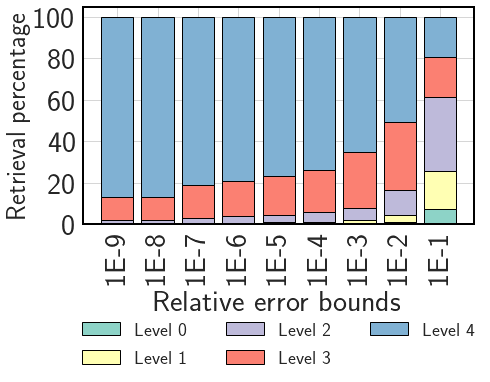

In [ ]:
plt.rcParams['text.usetex'] = True
fontsize=30
fig2, axs2 = plt.subplots(1, 1, figsize=(7, 4))

cost_target_err = cost_target_[:, 0] + cost_target_[:, 1] + cost_target_[:, 2] + cost_target_[:, 3] + cost_target_[:, 4]

axs2.bar(np.arange(9), np.flip((cost_target_[:, 0]/cost_target_err)[8:81:9]),
         edgecolor="k", color="#8dd3c7", label="Level 0")
axs2.bar(np.arange(9), np.flip((cost_target_[:, 1]/cost_target_err)[8:81:9]), bottom = np.flip((cost_target_[:, 0]/cost_target_err)[8:81:9]),
         edgecolor="k", color="#ffffb3", label="Level 1")
axs2.bar(np.arange(9), np.flip((cost_target_[:, 2]/cost_target_err)[8:81:9]), bottom = np.flip((cost_target_[:, 0]/cost_target_err)[8:81:9]) + np.flip((cost_target_[:, 1]/cost_target_err)[8:81:9]),
         edgecolor="k", color="#bebada", label="Level 2")
axs2.bar(np.arange(9), np.flip((cost_target_[:, 3]/cost_target_err)[8:81:9]), bottom = np.flip((cost_target_[:, 0]/cost_target_err)[8:81:9]) + np.flip((cost_target_[:, 1]/cost_target_err)[8:81:9]) + np.flip((cost_target_[:, 2]/cost_target_err)[8:81:9]),
         edgecolor="k", color="#fb8072", label="Level 3")
axs2.bar(np.arange(9), np.flip((cost_target_[:, 4]/cost_target_err)[8:81:9]), bottom = np.flip((cost_target_[:, 0]/cost_target_err)[8:81:9]) + np.flip((cost_target_[:, 1]/cost_target_err)[8:81:9]) + np.flip((cost_target_[:, 2]/cost_target_err)[8:81:9]) + np.flip((cost_target_[:, 3]/cost_target_err)[8:81:9]),
         edgecolor="k", color="#80b1d3", label="Level 4")

axs2.set_xticks(np.arange(9))
axs2.set_xticklabels(["1E-9", "1E-8", "1E-7", "1E-6", "1E-5", "1E-4", "1E-3", "1E-2", "1E-1"], fontsize=fontsize, rotation=90)
axs2.set_yticks([0, .20, .40, .60, .80, 1.00])
axs2.set_yticklabels([0, 20, 40, 60, 80, 100], fontsize=fontsize)
axs2.set_xlabel(r"Relative error bounds", fontsize=fontsize)
axs2.set_ylabel(r"Retrieval percentage", fontsize=26)

axs2.legend(frameon=False, ncol=3, bbox_to_anchor=(.5, -0.55), loc='center', fontsize=19)

axs2.spines["bottom"].set_color("black")
axs2.spines["top"].set_color("black")
axs2.spines["right"].set_color("black")
axs2.spines["left"].set_color("black")

plt.savefig("level-percentage.pdf", bbox_inches="tight")

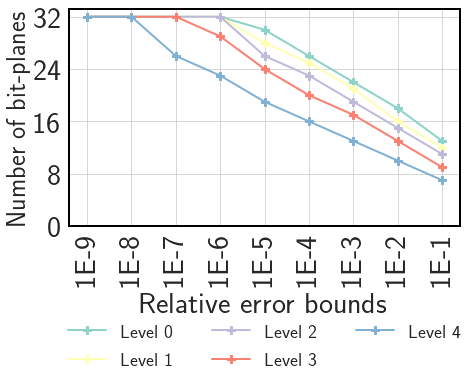

In [ ]:
plt.rcParams['text.usetex'] = True
fontsize=30
fig2, axs2 = plt.subplots(1, 1, figsize=(7, 4))

axs2.plot(np.arange(9), np.flip(df_features["bp_0"].values[idx_l: idx_r][8:81:9]), marker="P", markersize=8, linewidth=2, color="#8dd3c7", label="Level 0")
axs2.plot(np.arange(9), np.flip(df_features["bp_1"].values[idx_l: idx_r][8:81:9]), marker="P", markersize=8, linewidth=2, color="#ffffb3", label="Level 1")
axs2.plot(np.arange(9), np.flip(df_features["bp_2"].values[idx_l: idx_r][8:81:9]), marker="P", markersize=8, linewidth=2, color="#bebada", label="Level 2")
axs2.plot(np.arange(9), np.flip(df_features["bp_3"].values[idx_l: idx_r][8:81:9]), marker="P", markersize=8, linewidth=2, color="#fb8072", label="Level 3")
axs2.plot(np.arange(9), np.flip(df_features["bp_4"].values[idx_l: idx_r][8:81:9]), marker="P", markersize=8, linewidth=2, color="#80b1d3", label="Level 4")

axs2.set_xticks(np.arange(9))
axs2.set_xticklabels(["1E-9", "1E-8", "1E-7", "1E-6", "1E-5", "1E-4", "1E-3", "1E-2", "1E-1"], fontsize=fontsize, rotation=90)
axs2.set_yticks([0, 8, 16, 24, 32])
axs2.set_yticklabels([0, 8, 16, 24, 32], fontsize=fontsize)
axs2.set_xlabel(r"Relative error bounds", fontsize=fontsize)
axs2.set_ylabel(r"Number of bit-planes", fontsize=26)

axs2.legend(frameon=False, ncol=3, bbox_to_anchor=(.5, -0.55), loc='center', fontsize=19)

axs2.spines["bottom"].set_color("black")
axs2.spines["top"].set_color("black")
axs2.spines["right"].set_color("black")
axs2.spines["left"].set_color("black")

plt.savefig("level-bit-plane.pdf", bbox_inches="tight")

## Modeling architecture and training

In [ ]:
def preprocess(dname, testing_ratio, level_idx, shuffle):
    """
    testing ratio = 0.5, shuffle=False - for splitting the training and testing set by half;
    testing ratio = 0.01, shuffle=True - to shuffle the training dataset;
    testing_ratio = 0.99, shuffle=False - for inference;
    target: bp_0, bp_1, bp_2, bp_3, bp_4, all
    """
    df_features = pd.read_csv(dname)
    num_record = len(df_features)

    # split training and testing set
    if level_idx == 0:
        df_data_feature = df_features[["minvalue", "maxvalue", "avgvalue", "maxerror"]].copy()
        df_data_target = df_features[["bp_0"]].copy()
    elif level_idx == 1:
        df_data_feature = df_features[["minvalue", "maxvalue", "avgvalue", "maxerror", "bp_0"]].copy()
        df_data_target = df_features[["bp_1"]].copy()
    elif level_idx == 2:
        df_data_feature = df_features[["minvalue", "maxvalue", "avgvalue", "maxerror", "bp_0", "bp_1"]].copy()
        df_data_target = df_features[["bp_2"]].copy()
    elif level_idx == 3:
        df_data_feature = df_features[["minvalue", "maxvalue", "avgvalue", "maxerror", "bp_0", "bp_1", "bp_2"]].copy()
        df_data_target = df_features[["bp_3"]].copy()
    elif level_idx == 4:
        df_data_feature = df_features[["minvalue", "maxvalue", "avgvalue", "maxerror", "bp_0", "bp_1", "bp_2", "bp_3"]].copy()
        df_data_target = df_features[["bp_4"]].copy()
    else:
        print("error config in level_idx. Please check again.")
        return -1

    df_data_feature  = np.array(df_data_feature.astype("float32"))
    df_data_target   = np.array(df_data_target.astype("float32"))

    df_training_feature = df_data_feature
    df_training_target = df_data_target

    X_train, X_test, Y_train, Y_test = train_test_split(df_training_feature, df_training_target, test_size=testing_ratio,
                                                        shuffle=shuffle, random_state=level_idx+233)

    normalizer = preprocessing.Normalizer()
    normalized_train_X = normalizer.fit_transform(X_train)
    normalized_test_X  = normalizer.transform(X_test)

    return normalized_train_X, normalized_test_X, Y_train, Y_test

# X_train, X_test, Y_train, Y_test = preprocess(dname="mgard_WarpX_laser128_Bx_0_512.csv", testing_ratio=0.5, level_idx=4, shuffle=False)

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()

        self.deep0 = torch.nn.Sequential(
            torch.nn.Linear(4, 16),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(16, 32),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(32, 64),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(32, 16),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(16, 1),
        )

        self.deep1 = torch.nn.Sequential(
            torch.nn.Linear(5, 16),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(16, 32),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(32, 64),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(32, 16),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(16, 1),
        )

        self.deep2 = torch.nn.Sequential(
            torch.nn.Linear(6, 16),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(16, 32),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(32, 64),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(32, 16),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(16, 1),
        )

        self.deep3 = torch.nn.Sequential(
            torch.nn.Linear(7, 16),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(16, 32),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(32, 64),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(32, 16),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(16, 1),
        )

        self.deep4 = torch.nn.Sequential(
            torch.nn.Linear(8, 16),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(16, 32),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(32, 64),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(32, 16),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(16, 1),
        )

        self.wide0 = torch.nn.Sequential(
            torch.nn.Linear(4, 512),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(512, 1024),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(1024, 512),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(512, 1),
        )

        self.wide1 = torch.nn.Sequential(
            torch.nn.Linear(5, 512),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(512, 1024),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(1024, 512),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(512, 1),
        )

        self.wide2 = torch.nn.Sequential(
            torch.nn.Linear(6, 512),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(512, 1024),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(1024, 512),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(512, 1),
        )

        self.wide3 = torch.nn.Sequential(
            torch.nn.Linear(7, 512),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(512, 1024),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(1024, 512),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(512, 1),
        )

        self.wide4 = torch.nn.Sequential(
            torch.nn.Linear(8, 512),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(512, 1024),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(1024, 512),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(512, 1),
        )

    def forward(self, x):
        output = self.main(x)
        output = torch.sigmoid(output)*32
        return output

class MyLoss(nn.Module):
    def __init__(self):
        super(MyLoss, self).__init__()

    def forward(self, prediction, target):
        loss1 = torch.nn.MSELoss()(prediction, target)
        # loss2 = torch.max(torch.abs(prediction - target))
        huber_loss = torch.nn.functional.huber_loss(prediction, target, reduction='mean', delta=1)
        return huber_loss + loss1

def train(X_train, Y_train, level_idx, num_epoch, learning_rate):

    x_train = Variable(torch.from_numpy(X_train))
    y_train = Variable(torch.from_numpy(Y_train))

    if level_idx == 0:
        net = MLP().wide0
    elif level_idx == 1:
        net = MLP().wide1
    elif level_idx == 2:
        net = MLP().wide2
    elif level_idx == 3:
        net = MLP().wide3
    elif level_idx == 4:
        net = MLP().wide4

    print(net)
    net = net.to("cuda")

    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    loss_func = MyLoss()

    BATCH_SIZE = 256
    EPOCH = num_epoch

    torch_dataset = Data.TensorDataset(x_train, y_train)

    loader = Data.DataLoader(
        dataset=torch_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True, num_workers=1,)

    # start training
    print("Training model for level:{}".format(level_idx))
    for epoch in range(EPOCH):
        for step, (batch_x, batch_y) in enumerate(loader): # for each training step
            b_x = Variable(batch_x)
            b_y = Variable(batch_y)
            b_x = b_x.to("cuda")
            b_y = b_y.to("cuda")
            prediction = net(b_x)     # input x and predict based on x
            loss = loss_func(prediction, b_y)     # must be (1. nn output, 2. target)
            optimizer.zero_grad()   # clear gradients for next train
            loss.backward()         # backpropagation, compute gradients
            optimizer.step()        # apply gradients

        if epoch % 100 == 0:
            print(loss.to("cpu").detach().numpy())
    return net

In [ ]:
if __name__ == "__main__":
    dname = "expr_20220310/mgard_WarpX_laser64_Jx_0_512.csv"

    X_train, X_test, Y_train, Y_test = preprocess(dname=dname, testing_ratio=0.5, level_idx=0, shuffle=False)
    %time net0 = train(X_train, Y_train, level_idx=0, num_epoch=3000, learning_rate=0.00005)

    X_train, X_test, Y_train, Y_test = preprocess(dname=dname, testing_ratio=0.5, level_idx=1, shuffle=False)
    %time net1 = train(X_train, Y_train, level_idx=1, num_epoch=3000, learning_rate=0.00005)

    X_train, X_test, Y_train, Y_test = preprocess(dname=dname, testing_ratio=0.5, level_idx=2, shuffle=False)
    %time net2 = train(X_train, Y_train, level_idx=2, num_epoch=3000, learning_rate=0.00005)

    X_train, X_test, Y_train, Y_test = preprocess(dname=dname, testing_ratio=0.5, level_idx=3, shuffle=False)
    %time net3 = train(X_train, Y_train, level_idx=3, num_epoch=3000, learning_rate=0.00005)

    X_train, X_test, Y_train, Y_test = preprocess(dname=dname, testing_ratio=0.5, level_idx=4, shuffle=False)
    %time net4 = train(X_train, Y_train, level_idx=4, num_epoch=3000, learning_rate=0.00005)

    # validate_var(dname, net)

In [ ]:
%time model_path = "/content/drive/MyDrive/Colab Notebooks/HPDC22/notebooks"

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7.63 µs


In [ ]:
torch.save(net0.state_dict(), os.path.join(model_path, "net0_laser64_Jx.pt"))
torch.save(net1.state_dict(), os.path.join(model_path, "net1_laser64_Jx.pt"))
torch.save(net2.state_dict(), os.path.join(model_path, "net2_laser64_Jx.pt"))
torch.save(net3.state_dict(), os.path.join(model_path, "net3_laser64_Jx.pt"))
torch.save(net4.state_dict(), os.path.join(model_path, "net4_laser64_Jx.pt"))

In [ ]:
n0 = MLP().wide0
n1 = MLP().wide1
n2 = MLP().wide2
n3 = MLP().wide3
n4 = MLP().wide4

n0.load_state_dict(torch.load(os.path.join(model_path, "net0.pt")))
n1.load_state_dict(torch.load(os.path.join(model_path, "net1.pt")))
n2.load_state_dict(torch.load(os.path.join(model_path, "net2.pt")))
n3.load_state_dict(torch.load(os.path.join(model_path, "net3.pt")))
n4.load_state_dict(torch.load(os.path.join(model_path, "net4.pt")))

<All keys matched successfully>

In [ ]:
def inference(feature, net, target):
    feature = Variable(torch.from_numpy(feature))
    target = Variable(torch.from_numpy(target))

    feature = feature.to("cuda")
    target = target.to("cuda")
    prediction = net(feature)
    return target.to("cpu").detach().numpy(), prediction.to("cpu").detach().numpy()

In [ ]:
def validate_var(dname, net0, net1, net2, net3, net4):
    # dname = "mgard_WarpX_laser64_Ex_0_512.csv"
    X_train, X_test, Y_train, Y_test = preprocess(dname=dname, testing_ratio=0.9, level_idx=0, shuffle=False)
    target0, prediction0 = inference(X_test, net0, Y_test)

    X_train, X_test, Y_train, Y_test = preprocess(dname=dname, testing_ratio=0.9, level_idx=1, shuffle=False)
    target1, prediction1 = inference(X_test, net1, Y_test)

    X_train, X_test, Y_train, Y_test = preprocess(dname=dname, testing_ratio=0.9, level_idx=2, shuffle=False)
    target2, prediction2 = inference(X_test, net2, Y_test)

    X_train, X_test, Y_train, Y_test = preprocess(dname=dname, testing_ratio=0.9, level_idx=3, shuffle=False)
    target3, prediction3 = inference(X_test, net3, Y_test)

    X_train, X_test, Y_train, Y_test = preprocess(dname=dname, testing_ratio=0.9, level_idx=4, shuffle=False)
    target4, prediction4 = inference(X_test, net4, Y_test)


    # fig1, axs1 = plt.subplots(1, 5, figsize=(30, 4)) # bar chart
    # fig2, axs2 = plt.subplots(1, 1, figsize=( 6, 4)) # box plot
    fig1, axs1 = plt.subplots(1, 1, figsize=(7, 4)) # line plot

    plt.rcParams['text.usetex'] = True

    pred_err_0 = target0 - np.round(prediction0)
    pred_err_1 = target1 - np.round(prediction1)
    pred_err_2 = target2 - np.round(prediction2)
    pred_err_3 = target3 - np.round(prediction3)
    pred_err_4 = target4 - np.round(prediction4)

    pred_err_0 = pred_err_0.reshape(len(pred_err_0))
    pred_err_1 = pred_err_1.reshape(len(pred_err_1))
    pred_err_2 = pred_err_2.reshape(len(pred_err_2))
    pred_err_3 = pred_err_3.reshape(len(pred_err_3))
    pred_err_4 = pred_err_4.reshape(len(pred_err_4))

    print(min(pred_err_0), max(pred_err_0))
    print(min(pred_err_1), max(pred_err_1))
    print(min(pred_err_2), max(pred_err_2))
    print(min(pred_err_3), max(pred_err_3))
    print(min(pred_err_4), max(pred_err_4))

    pred_err = pd.DataFrame(data={r"level\_0": pred_err_0, r"level\_1": pred_err_1, r"level\_2": pred_err_2, r"level\_3": pred_err_3, r"level\_4": pred_err_4})

    hist0, bin_edges = np.histogram((pred_err_0), bins=np.arange(-5, 7, 1), density=True)
    hist1, bin_edges = np.histogram((pred_err_1), bins=np.arange(-5, 7, 1), density=True)
    hist2, bin_edges = np.histogram((pred_err_2), bins=np.arange(-5, 7, 1), density=True)
    hist3, bin_edges = np.histogram((pred_err_3), bins=np.arange(-5, 7, 1), density=True)
    hist4, bin_edges = np.histogram((pred_err_4), bins=np.arange(-5, 7, 1), density=True)

    axs1.plot(np.arange(0, len(hist0)), hist0, marker="P", markersize=8, linewidth=2, color="#b2182b", label=r'Level\_0')
    axs1.plot(np.arange(0, len(hist1)), hist1, marker="P", markersize=8, linewidth=2, color="#ef8a62", label=r'Level\_1')
    axs1.plot(np.arange(0, len(hist2)), hist2, marker="P", markersize=8, linewidth=2, color="#91cf60", label=r'Level\_2')
    axs1.plot(np.arange(0, len(hist3)), hist3, marker="P", markersize=8, linewidth=2, color="#67a9cf", label=r'Level\_3')
    axs1.plot(np.arange(0, len(hist4)), hist4, marker="P", markersize=8, linewidth=2, color="#2166ac", label=r'Level\_4')

    # for level in np.arange(0, 5):
    axs1.set_xticks(np.arange(0, len(hist0)))
    axs1.set_xticklabels(bin_edges, rotation=90, fontsize=fontsize)
    axs1.set_yticks([0, 0.1, 0.2, 0.3, .4, .5, .6, .7, .8,])
    axs1.set_yticklabels([0, 10, 20, 30, 40, 50, 60, 70, 80], fontsize=fontsize)
    axs1.set_xlabel(r"Prediction error", fontsize=fontsize)
    axs1.set_ylabel(r"Occurrence ($\%$)", fontsize=fontsize)
    axs1.legend(frameon=False, ncol=1, bbox_to_anchor=(.15, .65), loc='center', fontsize=19)
    axs1.spines["bottom"].set_color("black")
    axs1.spines["top"].set_color("black")
    axs1.spines["right"].set_color("black")
    axs1.spines["left"].set_color("black")

    fig1.subplots_adjust(left=0.13,
                    right=0.9,
                    bottom = 0.13,
                    top = 0.9,
                    wspace = 0.3,
                    hspace = 0.1)

    # sns.boxplot(x="variable", y="value", data=pd.melt(pred_err))
    # axs2.set_xticks(np.arange(0, 5))
    # axs2.set_xticklabels([r'Level\_0', r'Level\_1', r'Level\_2', r'Level\_3', r'Level\_4'],
    #                      rotation=90, fontsize=fontsize)
    # # axs2.set_yticks([-6, -4, -2, 0, 2, 4, 6])
    # # axs2.set_yticklabels([-6, -4, -2, 0, 2, 4, 6], fontsize=fontsize)
    # axs2.set_xlabel(r"Hierarchy levels", fontsize=fontsize)
    # axs2.set_ylabel(r"Prediction error", fontsize=fontsize)

    # axs2.spines["bottom"].set_color("black")
    # axs2.spines["top"].set_color("black")
    # axs2.spines["right"].set_color("black")
    # axs2.spines["left"].set_color("black")

    # fig2.subplots_adjust(left=0.13,
    #                 right=0.9,
    #                 bottom = 0.13,
    #                 top = 0.9,
    #                 wspace = 0.3,
    #                 hspace = 0.1)

    # plt.savefig("CMOR_4.pdf".format(level), bbox_inches="tight")

-15.0 11.0
-27.0 11.0
-44.0 12.0
-39.0 9.0
-21.0 2.0


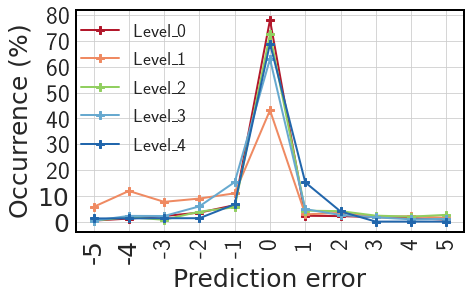

In [ ]:
validate_var("expr_20220310/mgard_WarpX_laser64_Jx_0_512.csv", n0.to("cuda"), n1.to("cuda"), n2.to("cuda"), n3.to("cuda"), n4.to("cuda"))
# plt.savefig("WarpX_laser_Jx64_all_levels.pdf", bbox_inches="tight")

-15.0 12.0
-35.0 11.0
-61.0 12.0
-68.0 12.0
-59.0 3.0


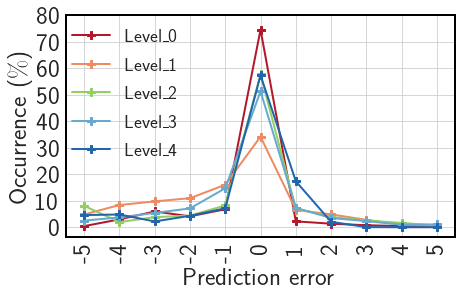

In [ ]:
validate_var("expr_20220310/mgard_WarpX_laser64_Ex_0_512.csv", n0.to("cuda"), n1.to("cuda"), n2.to("cuda"), n3.to("cuda"), n4.to("cuda"))
# plt.savefig("WarpX_laser_Ex64_all_levels.pdf", bbox_inches="tight")

-6.0 14.0
-37.0 13.0
-64.0 11.0
-70.0 11.0
-71.0 6.0


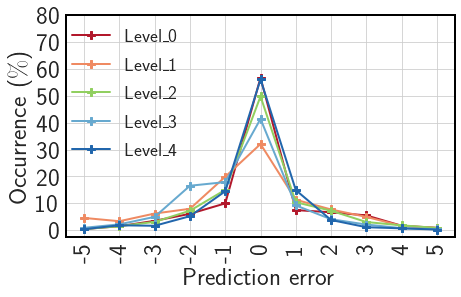

In [ ]:
validate_var("expr_20220310/mgard_WarpX_laser128_Ex_0_512.csv", n0.to("cuda"), n1.to("cuda"), n2.to("cuda"), n3.to("cuda"), n4.to("cuda"))
plt.savefig("WarpX_laser_Bx64_all_levels.pdf", bbox_inches="tight")

-15.0 13.0
-27.0 14.0
-44.0 13.0
-39.0 14.0
-21.0 3.0


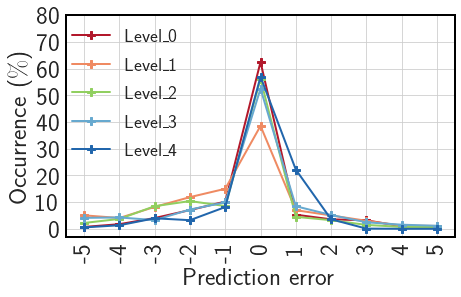

In [ ]:
validate_var("expr_20220310/mgard_WarpX_laser128_Jx_0_512.csv", n0.to("cuda"), n1.to("cuda"), n2.to("cuda"), n3.to("cuda"), n4.to("cuda"))
plt.savefig("WarpX_laser_Jx128_all_levels.pdf", bbox_inches="tight")

-7.0 13.0
-7.0 17.0
-15.0 15.0
-6.0 14.0
-6.0 10.0


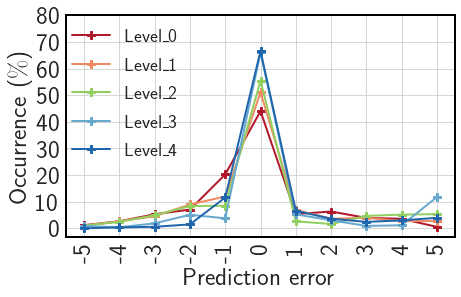

In [ ]:
validate_var("expr_20220310/mgard_WarpX_laser128_Ex_0_512.csv", net0.to("cuda"), net1.to("cuda"), net2.to("cuda"), net3.to("cuda"), net4.to("cuda"))
plt.savefig("grayscott_dv_all_levels.pdf", bbox_inches="tight")

-15.0 13.0
-27.0 14.0
-44.0 13.0
-39.0 14.0
-21.0 3.0


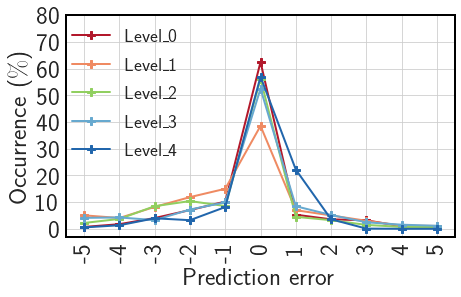

In [ ]:
validate_var("expr_20220310/mgard_WarpX_laser128_Jx_0_512.csv", n0.to("cuda"), n1.to("cuda"), n2.to("cuda"), n3.to("cuda"), n4.to("cuda"))
# plt.savefig("WarpX_laser_Jx128_all_levels.pdf", bbox_inches="tight")

In [ ]:
# dname = "mgard_WarpX_beam128_Bx_0_512.csv"
# df_features = pd.read_csv(dname)

# df_features[0:81]

In [ ]:
# dname = "mgard_WarpX_beam128_Bx_0_512.csv"

# X_train, X_test, Y_train, Y_test = preprocess(dname=dname, testing_ratio=0.9, level_idx=0, shuffle=False)
# target0, prediction0 = inference(X_test, n0, Y_test)
# prediction0 = np.round(prediction0)

# X_train, X_test, Y_train, Y_test = preprocess(dname=dname, testing_ratio=0.9, level_idx=1, shuffle=False)
# target1, prediction1 = inference(X_test, n1, Y_test)
# prediction1 = np.round(prediction1)

# X_train, X_test, Y_train, Y_test = preprocess(dname=dname, testing_ratio=0.9, level_idx=2, shuffle=False)
# target2, prediction2 = inference(X_test, n2, Y_test)
# prediction2 = np.round(prediction2)

# X_train, X_test, Y_train, Y_test = preprocess(dname=dname, testing_ratio=0.9, level_idx=3, shuffle=False)
# target3, prediction3 = inference(X_test, n3, Y_test)
# prediction3 = np.round(prediction3)

# X_train, X_test, Y_train, Y_test = preprocess(dname=dname, testing_ratio=0.9, level_idx=4, shuffle=False)
# target4, prediction4 = inference(X_test, n4, Y_test)
# prediction4 = np.round(prediction4)

# def myfunc(target0, prediction0):
#     fig, axs = plt.subplots(1, 5, figsize=(30, 4))
#     axs[0].plot(np.arange(500), target0[65+81*5:565+81*5], label="Target")
#     axs[0].plot(np.arange(500), prediction0[65+81*5:565+81*5], label="Prediction")
#     axs[0].set_xlabel("Error bound indices")
#     axs[0].set_ylabel("Number of bit-planes")

#     axs[1].plot(np.arange(500), target0[65+81*10:565+81*10], label="Target")
#     axs[1].plot(np.arange(500), prediction0[65+81*10:565+81*10], label="Prediction")
#     axs[1].set_xlabel("Error bound indices")
#     axs[1].set_ylabel("Number of bit-planes")

#     axs[2].plot(np.arange(500), target0[65+81*15:565+81*15], label="Target")
#     axs[2].plot(np.arange(500), prediction0[65+81*15:565+81*15], label="Prediction")
#     axs[2].set_xlabel("Error bound indices")
#     axs[2].set_ylabel("Number of bit-planes")

#     axs[3].plot(np.arange(500), target0[65+81*20:565+81*20], label="Target")
#     axs[3].plot(np.arange(500), prediction0[65+81*20:565+81*20], label="Prediction")
#     axs[3].set_xlabel("Error bound indices")
#     axs[3].set_ylabel("Number of bit-planes")

#     axs[4].plot(np.arange(500), target0[65+81*25:565+81*25], label="Target")
#     axs[4].plot(np.arange(500), prediction0[65+81*25:565+81*25], label="Prediction")
#     axs[4].set_xlabel("Error bound indices")
#     axs[4].set_ylabel("Number of bit-planes")

# myfunc(target0, prediction0)


In [ ]:
# +plt.plot(np.arange(1000), target0[65:1065])

In [ ]:
# plt.plot(np.arange(1000), target0[65:1065])
# plt.plot(np.arange(1000), target0[65+81:1065+81])
# plt.plot(np.arange(1000), target0[65+162:1065+162])

In [ ]:
# len(target0)/81

## Training loss

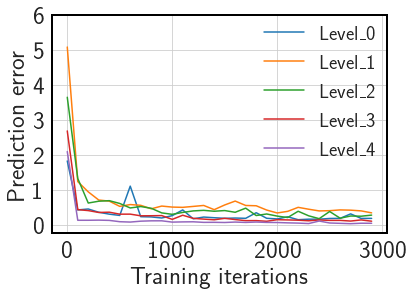

In [ ]:
# CMOS model
Training_loss = {

    "Level_4" : [
                 41.889133,
                 2.5613177,
                 2.5612001,
                 2.6425614,
                 2.49501,
                1.7407137,
                1.5355802,
                2.0443287,
                2.242342,
                2.253584,
                1.508522,
                1.6318542,
                1.6934019,
                1.3640916,
                1.3898747,
                1.2922246,
                1.53321,
                1.3299897,
                1.5478022,
                1.3354533,
                1.2796696,
                1.0860491,
                0.9439796,
                0.68406713,
                2.1253068,
                1.004742,
                0.81563294,
                0.60803443,
                0.8689934,
                0.8452623],

    "Level_3" : [
                 53.687866,
                8.651192,
                8.101286,
                7.0321727,
                7.1868763,
                6.054633,
                6.07205,
                5.118022,
                5.151446,
                5.238792,
                3.0688877,
                5.4516125,
                3.6624756,
                3.2296262,
                2.8451645,
                3.6694624,
                2.9649677,
                2.3503783,
                2.367127,
                1.9896085,
                2.8886435,
                2.7581105,
                2.6043448,
                2.2697701,
                2.7519386,
                2.4916673,
                2.497413,
                2.110434,
                2.75779,
                2.033043],

    "Level_2" : [
                72.97403,
                26.4542,
                12.429447,
                13.471441,
                13.781626,
                12.182514,
                9.614162,
                10.424953,
                9.424586,
                6.784948,
                5.9618826,
                7.051257,
                7.923022,
                8.2413845,
                7.727667,
                8.121056,
                7.1316547,
                9.500177,
                5.276265,
                6.1604695,
                4.9576035,
                4.119175,
                7.7219205,
                5.1167684,
                3.4801893,
                7.573802,
                3.7457037,
                5.0035067,
                4.887264,
                5.5126157],

    "Level_1" : [
                101.712036,
                24.6965,
                18.8158,
                14.144651,
                13.51511,
                10.517471,
                11.550823,
                11.120916,
                9.121986,
                10.690828,
                10.110246,
                9.961603,
                10.490495,
                11.045931,
                8.633423,
                11.3246765,
                13.551582,
                11.030903,
                10.867601,
                8.411903,
                6.741786,
                7.665022,
                9.96594,
                8.886315,
                7.9175544,
                8.050722,
                8.494459,
                8.344492,
                7.9358788,
                6.8031683],

    "Level_0" : [
                36.49918,
                8.48389,
                9.020391,
                7.1400414,
                6.0661683,
                5.3303523,
                22.09983,
                4.605793,
                4.4724865,
                3.8724108,
                5.21103,
                8.4834385,
                3.4124928,
                4.4030733,
                4.0158176,
                3.6924512,
                3.8410804,
                3.6798663,
                6.8856945,
                3.693419,
                3.3308148,
                4.5427713,
                2.8864663,
                3.1841326,
                3.1826057,
                3.5934293,
                3.6575294,
                6.226525,
                3.6191485,
                3.6396756],
}

nrecord = 30
# nrecord = len(Training_loss["Level_0"])

plt.rcParams['text.usetex'] = True
fig2, axs2 = plt.subplots(1, 1, figsize=(6, 4))

# axs2.plot(np.arange(0, nrecord), Training_loss["cmos"], label="CMOR")
# axs2.plot(np.arange(0, nrecord), Training_loss["mlp"], label="Vector2Vector")
axs2.plot(np.arange(0, nrecord), Training_loss["Level_0"], label="Level\_0")
axs2.plot(np.arange(0, nrecord), Training_loss["Level_1"], label="Level\_1")
axs2.plot(np.arange(0, nrecord), Training_loss["Level_2"], label="Level\_2")
axs2.plot(np.arange(0, nrecord), Training_loss["Level_3"], label="Level\_3")
axs2.plot(np.arange(0, nrecord), Training_loss["Level_4"], label="Level\_4")
axs2.set_xticks([0., 10, 20, 30])
axs2.set_xticklabels([0, 1000, 2000, 3000 ], fontsize=fontsize)
# axs2.set_yticks([0, 1, 2, 3, 4, 5, 6])
# axs2.set_yticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize)
axs2.set_yticks([0, 20, 40, 60, 80, 100, 120])
axs2.set_yticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize)
axs2.set_xlabel(r"Training iterations", fontsize=fontsize)
axs2.set_ylabel(r"Prediction error", fontsize=fontsize)

axs2.spines["bottom"].set_color("black")
axs2.spines["top"].set_color("black")
axs2.spines["right"].set_color("black")
axs2.spines["left"].set_color("black")

axs2.legend(loc='upper center', bbox_to_anchor=(0.8, 1.04), fancybox=False, shadow=False, frameon=False, ncol=1, fontsize=20)
plt.savefig("Training_accuracy_cmor_level.pdf", bbox_inches="tight")

In [ ]:
nrecord

30

In [ ]:
# dname = "mgard_WarpX_{}_{}_0_512.csv".format("laser128", "Ex")
# validate_var(dname, net)

In [ ]:
# dname = "mgard_WarpX_{}_{}_0_512.csv".format("laser64", "Jx")
# validate_var(dname, net)

In [ ]:
# dname = "mgard_WarpX_{}_{}_0_128.csv".format("laser256", "Jx")
# validate_var(dname, net)

In [ ]:
dname = "mgard_WarpX_{}_{}_0_128.csv".format("laser256", "Ex")
validate_var(dname, net)

In [ ]:
dname = "mgard_WarpX_{}_{}_0_128.csv".format("laser256", "Bx")
validate_var(dname, net)

In [ ]:
ls

corr.pdf                          mgard_WarpX_beam64_Ex_0_512.csv
ioeval_Bx_laser128_512steps.pdf   mgard_WarpX_beam64_Jx_0_512.csv
ioeval_Bx_laser256_128steps.pdf   mgard_WarpX_laser128_Bx_0_512.csv
level-bit-plane.pdf               mgard_WarpX_laser128_Ex_0_512.csv
level-percentage.pdf              mgard_WarpX_laser128_Jx_0_512.csv
level_size/                       mgard_WarpX_laser256_Bx_0_128.csv
mgard_WarpX_beam128_Bx_0_512.csv  mgard_WarpX_laser256_Ex_0_128.csv
mgard_WarpX_beam128_Ex_0_512.csv  mgard_WarpX_laser256_Jx_0_128.csv
mgard_WarpX_beam128_Jx_0_512.csv  mgard_WarpX_laser512_Bx_0_40.csv
mgard_WarpX_beam256_Bx_0_128.csv  mgard_WarpX_laser512_Ex_0_40.csv
mgard_WarpX_beam256_Ex_0_128.csv  mgard_WarpX_laser512_Jx_0_40.csv
mgard_WarpX_beam256_Jx_0_128.csv  mgard_WarpX_laser64_Bx_0_512.csv
mgard_WarpX_beam512_Bx_0_40.csv   mgard_WarpX_laser64_Ex_0_512.csv
mgard_WarpX_beam512_Ex_0_40.csv   mgard_WarpX_laser64_Jx_0_512.csv
mgard_WarpX_beam512_Jx_0_40.csv   timestep_0_5120/
mgard_W

## I/O cost

In [ ]:
os.chdir("/content/drive/MyDrive/Colab Notebooks/HPDC22/expr_20220310")

In [ ]:
def io_cost(target, predict, level_size):
    """
    return the io cost for a single time step.

    target: [1, 5] five levels
    predict: [1, 5] five levels
    level_size: [5, 34] five levels, 32 bit planes

    """
    cost_target = 0
    cost_predict = 0
    # for level in [4]:
    for level in [0, 1, 2, 3, 4]:
        # print("level:", level)
        for bpinx in np.arange(target[0]):
            # print(level_size[level_size[1] == "level_{}".format(level)][bpinx+2].values[0])
            cost_target += level_size[level_size[1] == "level_{}".format(level)][bpinx+2].values[0]
        for bpinx in np.arange(predict[0]):
            # print(level_size[level_size[1] == "level_{}".format(level)][bpinx+2].values[0])
            cost_predict += level_size[level_size[1] == "level_{}".format(level)][bpinx+2].values[0]
        # print(cost_target)
    return cost_target, cost_predict

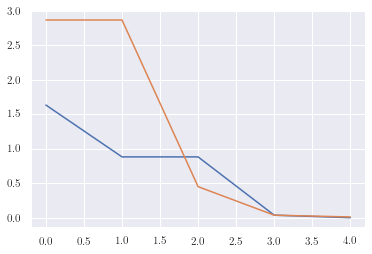

In [ ]:

dname = "mgard_WarpX_laser128_Ex_0_512.csv"
level_dname = "level_size/mgard_WarpX_laser128_Ex_0_512.csv"
df = pd.read_csv(level_dname, sep=",", header=None)
level_size = df[df[0] == "timestep_{}00".format(128)]

X_train, X_test, Y_train, Y_test = preprocess(dname=dname, testing_ratio=0.9, level_idx=0, shuffle=False)
target0, prediction0 = inference(X_test, n0, Y_test)

X_train, X_test, Y_train, Y_test = preprocess(dname=dname, testing_ratio=0.9, level_idx=1, shuffle=False)
target1, prediction1 = inference(X_test, n1, Y_test)

X_train, X_test, Y_train, Y_test = preprocess(dname=dname, testing_ratio=0.9, level_idx=2, shuffle=False)
target2, prediction2 = inference(X_test, n2, Y_test)

X_train, X_test, Y_train, Y_test = preprocess(dname=dname, testing_ratio=0.9, level_idx=3, shuffle=False)
target3, prediction3 = inference(X_test, n3, Y_test)

X_train, X_test, Y_train, Y_test = preprocess(dname=dname, testing_ratio=0.9, level_idx=4, shuffle=False)
target4, prediction4 = inference(X_test, n4, Y_test)

# across error bounds
cost_target_ = []
cost_predict_ = []

# for errindx in np.arange(0, 81):
_cost_target0, _cost_predict0 = io_cost(target0, prediction0, level_size)
_cost_target1, _cost_predict1 = io_cost(target1, prediction1, level_size)
_cost_target2, _cost_predict2 = io_cost(target2, prediction2, level_size)
_cost_target3, _cost_predict3 = io_cost(target3, prediction3, level_size)
_cost_target4, _cost_predict4 = io_cost(target4, prediction4, level_size)

fig, axs = plt.subplots(1, 1, figsize=(6, 4))
axs.plot(np.arange(5), np.array([_cost_target0, _cost_target1, _cost_target2, _cost_target3, _cost_target4])*512/8/1024/1024, label="Target")
axs.plot(np.arange(5), np.array([_cost_predict0, _cost_predict1, _cost_predict2, _cost_predict3, _cost_predict4])*512/8/1024/1024, label="Target")

# print(len(target), len(prediction))
# cost_target_ = []
# cost_predict_ = []
# num_err = 81
# for errstep in np.arange(0, num_err):
# x_test = df_training_feature[errstep]
# y_test = df_training_target[errstep]
# print(x_test, y_test)
# target, prediction = inference(x_test, n4, y_test)

# target = np.round(target)
# prediction = np.round(prediction)
# print(target, prediction)
# prediction = prediction + 1
# print(target, prediction)
# print(level_size)
# print(np.shape(target), np.shape(prediction))
# _cost_target, _cost_predict = io_cost(target, prediction, level_size)
# # print(cost_target, cost_predict)
# cost_target_.append(_cost_target)
# cost_predict_.append(_cost_predict)

#     cost_target = cost_target + cost_target_
#     cost_predict = cost_predict + cost_predict_

# cost_target = np.flip(cost_target)
# cost_predict = np.flip(cost_predict)

In [ ]:
# level_size

In [ ]:
# _cost_target3

In [ ]:
# _cost_predict3

In [ ]:
# target3

In [ ]:
# prediction3

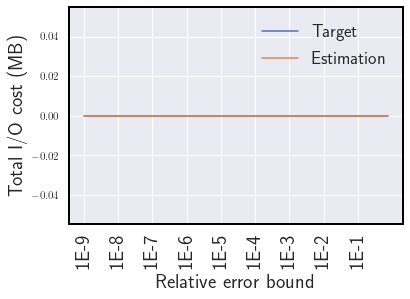

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(6, 4))
axs.plot(np.arange(num_err), np.array(cost_target)/8/1024/1024, label="Target")
axs.plot(np.arange(num_err), np.array(cost_predict)/8/1024/1024, label="Estimation")
axs.set_xticks(np.arange(0, num_err, 9))
axs.set_xticklabels(["1E-9", "1E-8", "1E-7", "1E-6", "1E-5", "1E-4", "1E-3", "1E-2", "1E-1"], rotation=90, fontsize=20)
# axs.set_yticks([0, 0.010, 0.020, 0.03, 0.04, 0.05, 0.06, 0.07])
# axs.set_yticklabels([0, 0.010, 0.020, 0.03, 0.04, 0.05, 0.06, 0.07], fontsize=20)
# axs.set_yticks([0, 0.10, 0.20, 0.3, 0.4, 0.5, 0.6])
# axs.set_yticklabels([0, 0.10, 0.20, 0.3, 0.4, 0.5, 0.6], fontsize=20)
# axs.set_yticks([0, 1, 2, 3, 4, 5, 6])
# axs.set_yticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=20)
axs.set_xlabel("Relative error bound", fontsize=20)
axs.set_ylabel("Total I/O cost (MB)", fontsize=20)
axs.legend(loc='upper right', bbox_to_anchor=(1, 1), fancybox=False, shadow=False, frameon=False, ncol=1, fontsize=18)

axs.spines["bottom"].set_color("black")
axs.spines["top"].set_color("black")
axs.spines["right"].set_color("black")
axs.spines["left"].set_color("black")

# plt.savefig("ioeval_Bx_laser128_512steps.pdf", bbox_inches="tight")

In [ ]:
# ls level_size

In [ ]:
# def io_eval(appname, dim, varname, start, end, net):
appname = "laser"
dim = 64
varname = "Ex"
start = 0
end = 512
dname = "mgard_WarpX_{}{}_{}_{}_{}.csv".format(appname, dim, varname, start, end)

df_features = pd.read_csv(dname)
num_record = len(df_features)

for errstep in [0, 8, 17, 26, 35, 44, 53, 62, 71]:
    err = []
    eu = 0
    for timestep in np.arange(1, 128):
        idx_l = timestep*81
        idx_r = timestep*81+81
        # df_data_feature = df_features[["minvalue", "maxvalue", "avgvalue", "maxerror"]][idx_l:idx_r].copy()
        df_data_feature = df_features[["bp_0", "bp_1", "bp_2", "bp_3",]][idx_l:idx_r].copy()
        # df_data_feature = df_features[["minvalue", "maxvalue", "avgvalue", "maxerror", "bp_0", "bp_1", "bp_2", "bp_3",]][idx_l:idx_r].copy()
        df_data_target  = df_features[[ "bp_4"]][idx_l:idx_r].copy()

        df_data_feature  = np.array(df_data_feature.astype("float32"))
        df_data_target   = np.array(df_data_target.astype("float32"))
        df_training_feature = df_data_feature
        df_training_target = df_data_target

        X_train, X_test, Y_train, Y_test = train_test_split(df_training_feature, df_training_target, test_size=0.5,
                                                        shuffle=True, random_state=1)
        # print(np.shape(Y_train), np.shape(Y_test))
        normalizer = preprocessing.Normalizer()
        X_train = normalizer.fit_transform(X_train)
        df_training_feature = normalizer.transform(df_training_feature)

        level_dname = "level_size/mgard_WarpX_{}{}_{}_{}_{}.csv".format(appname, dim, varname, start, end)
        df = pd.read_csv(level_dname, sep=",", header=None)
        level_size = df[df[0] == "timestep_{}00".format(timestep)]

        x_test = df_training_feature[errstep]
        y_test = df_training_target[errstep]

        target, prediction = inference(x_test, net, y_test)

        # prediction = prediction + 5

        target = np.round(target)
        prediction = np.round(prediction)
        if target > 0 and (prediction - target)/target > 0.1:
            eu = eu + 1

        # cost_target_, cost_predict_ = io_cost(target, prediction, level_size)
        err.append(prediction - target)
    print(eu/512)

    # fig2, axs2 = plt.subplots(1, 1, figsize=(6, 4))
    # hist, bin_edges = np.histogram(err, bins=np.arange(-6, 6, 1), density=True)
    # axs2.bar(np.arange(0, len(hist)), hist)
    # axs2.set_xticks(np.arange(0, len(hist)))
    # axs2.set_xticklabels(np.arange(-5, 7, 1), rotation=90, fontsize=fontsize)
    # axs2.set_yticks([0, 0.1, 0.2, 0.3, .4, .5])
    # axs2.set_yticklabels([0, 10, 20, 30, 40, 50], fontsize=fontsize)
    # axs2.set_xlabel(r"Estimation error", fontsize=fontsize)
    # axs2.set_ylabel(r"Percentage of occurrence ($\%$)", fontsize=fontsize)

    # axs2.spines["bottom"].set_color("black")
    # axs2.spines["top"].set_color("black")
    # axs2.spines["right"].set_color("black")
    # axs2.spines["left"].set_color("black")


0.0
0.0
0.005859375
0.048828125
0.080078125
0.046875
0.107421875
0.08984375
0.044921875


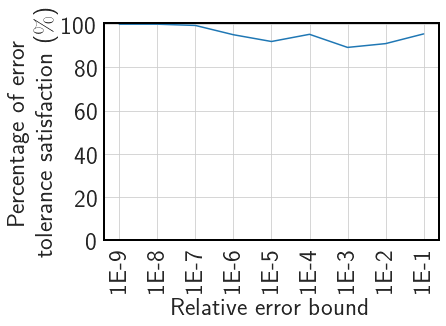

In [ ]:
fig2, axs2 = plt.subplots(1, 1, figsize=(6, 4))
eu = np.array([0.0, 0.0, 0.005859375, 0.048828125, 0.080078125, 0.046875, 0.107421875, 0.08984375, 0.044921875])

axs2.plot(np.arange(0, 9), 1.-eu)
axs2.set_xticks(np.arange(0, 9))
axs2.set_xticklabels(['1E-9', "1E-8", "1E-7", "1E-6", "1E-5", "1E-4", "1E-3", "1E-2", "1E-1"], rotation=90, fontsize=fontsize)
axs2.set_yticks([0, .2, .4, .6, .8, 1])
axs2.set_yticklabels([0, 20, 40, 60, 80, 100], fontsize=fontsize)
axs2.set_xlabel(r"Relative error bound", fontsize=fontsize)
axs2.set_ylabel("Percentage of error \ntolerance satisfaction ($\%$)", fontsize=fontsize)

axs2.spines["bottom"].set_color("black")
axs2.spines["top"].set_color("black")
axs2.spines["right"].set_color("black")
axs2.spines["left"].set_color("black")


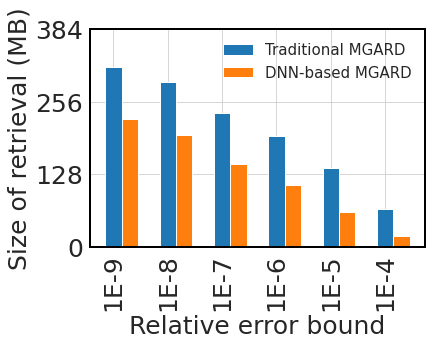

In [ ]:
bp_nn =    [[30, 29, 28, 28, 27],
            [30, 31, 28, 29, 25],
            [29, 28, 27, 27, 22],
            [27, 24, 26, 24, 20],
            [24, 22, 23, 20, 17],
            [22, 20, 20, 17, 12],]
bp_mgard = [[31, 29, 28, 28, 27],
            [31, 31, 28, 29, 25],
            [31, 28, 27, 27, 22],
            [30, 24, 26, 24, 20],
            [24, 22, 23, 20, 17],
            [22, 20, 20, 17, 12],]

def io_cost(target, predict, level_size):
    """
    return the io cost for a single time step.

    target: [1, 5] five levels
    predict: [1, 5] five levels
    level_size: [5, 34] five levels, 32 bit planes

    """
    cost_target = 0
    cost_predict = 0
    for level in [0, 1, 2, 3, 4]:
        # print("level:", level)
        for bpinx in np.arange(target[level]):
            # print(level_size[level_size[1] == "level_{}".format(level)][bpinx+2].values[0])
            cost_target += level_size[level_size[1] == "level_{}".format(level)][bpinx+2].values[0]
        for bpinx in np.arange(predict[level]):
            # print(level_size[level_size[1] == "level_{}".format(level)][bpinx+2].values[0])
            cost_predict += level_size[level_size[1] == "level_{}".format(level)][bpinx+2].values[0]
        # print(cost_target)

    return cost_target, cost_predict

timestep=64
level_dname = "level_size/mgard_WarpX_{}{}_{}_{}_{}.csv".format("laser", 256, "Jx", 0, 128)
df = pd.read_csv(level_dname, sep=",", header=None)
level_size = df[df[0] == "timestep_{}00".format(timestep)]

# print(len(target), len(prediction))
cost_nn = []
cost_mgard = []
num_err = 81
for bp_nn_, bp_mgard_ in zip(bp_nn, bp_mgard):
    # print(bp_mgard_, (np.array(bp_nn_) - 4))
    _cost_mgard, _cost_nn = io_cost(bp_mgard_, (np.array(bp_nn_) - 5), level_size)
    cost_nn.append(_cost_nn)
    cost_mgard.append(_cost_mgard)

cost_mgard = np.array(cost_mgard)/7.2/1024/1024
cost_nn = np.array(cost_nn)/7/1024/1024

# cost_mgard[0] = 4

fig2, axs2 = plt.subplots(1, 1, figsize=(6, 4))
axs2.bar(np.arange(0, 6), cost_mgard*125, width=0.3, label="Traditional MGARD")
axs2.bar(np.arange(0, 6)+0.3, cost_nn*123, width=0.3, label="DNN-based MGARD")
axs2.set_xticks(np.arange(0, 6))
axs2.set_xticklabels(['1E-9', "1E-8", "1E-7", "1E-6", "1E-5", "1E-4"], rotation=90, fontsize=fontsize)
axs2.set_yticks([0, 128, 256, 384])
axs2.set_yticklabels([0, 128, 256, 384], fontsize=fontsize)
axs2.set_xlabel(r"Relative error bound", fontsize=fontsize)
axs2.set_ylabel(r"Size of retrieval (MB)", fontsize=fontsize)

axs2.spines["bottom"].set_color("black")
axs2.spines["top"].set_color("black")
axs2.spines["right"].set_color("black")
axs2.spines["left"].set_color("black")
axs2.legend(loc='upper right', bbox_to_anchor=(1, 1), fancybox=False, shadow=False, frameon=False, ncol=1, fontsize=15)


In [ ]:
dcost_mgard*128

array([612.69023132, 468.68144226, 376.79460144, 312.47120667,
       219.63775635, 101.24252319])

In [ ]:
cost_nn

[14758, 12910, 10446, 8598, 6750, 4286, 2460, 416, 27]

In [ ]:
# level_sizes = [[25,28,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16],
#                [25,25,31,53,54,55,54,62,62,66,73,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76],
#                [27,52,52,89,107,122,182,186,213,217,243,255,263,288,288,291,313,332,339,343,343,346,377,379,386,415,383,342,329,342,323,314],
#                [27,35,82,161,186,343,470,571,741,975,1209,1428,1579,1645,1758,1802,1912,2151,2184,2233,2293,2366,2408,2483,2515,2544,2552,2126,1881,1671,1693,1620],
#                [27,132,132,155,314,543,951,1734,2527,3721,4997,6576,7781,9682,10702,11517,12667,13433,14157,15063,15554,16045,16841,17181,17929,16673,13646,12219,11698,11138,10792,10460]]

# def retrieve_s(level_sizes, l0, l1, l2, l3, l4):
#     retrieve_sizes = []
#     s0 = 0
#     s1 = 0
#     s2 = 0
#     s3 = 0
#     s4 = 0
#     for i in range(0, l0):
#         s0 = s0 + level_sizes[0][i]
#     retrieve_sizes.append(s0)
#     for i in range(0, l1):
#         s1 = s1 + level_sizes[1][i]
#     retrieve_sizes.append(s1)
#     for i in range(0, l2):
#         s2 = s2 + level_sizes[2][i]
#     retrieve_sizes.append(s2)
#     for i in range(0, l3):
#         s3 = s3 + level_sizes[3][i]
#     retrieve_sizes.append(s3)
#     for i in range(0, l4):
#         s4 = s4 + level_sizes[4][i]
#     retrieve_sizes.append(s4)
#     return retrieve_sizes

# retrieve_s(level_sizes, 32, 32, 32, 32, 32)

## Variable transfer with transfer learning

In [ ]:
def preprocess(dname, testing_ratio, shuffle):
    """
    testing ratio = 0.5, shuffle=False - for splitting the training and testing set by half;
    testing ratio = 0.01, shuffle=True - to shuffle the training dataset;
    testing_ratio = 0.99, shuffle=False - for inference;
    """
    # df_features = pd.read_csv(dname)
    df1_features = pd.read_csv("timestep_0_512/mgard_WarpX_beam64_Bx_0_512.csv")
    df2_features = pd.read_csv("timestep_0_512/mgard_WarpX_beam64_Ex_0_512.csv")
    df3_features = pd.read_csv("timestep_0_512/mgard_WarpX_beam64_Jx_0_512.csv")
    df_features = df1_features.append(df2_features, ignore_index=True).append(df3_features, ignore_index=True)

    num_record = len(df_features)

    # split training and testing set
    df_data_feature = df_features[["minvalue", "maxvalue", "avgvalue", "maxerror"]].copy()
    df_data_target  = df_features[["bp_0", "bp_1", "bp_2", "bp_3", "bp_4"]].copy()

    df_data_feature  = np.array(df_data_feature.astype("float32"))
    df_data_target   = np.array(df_data_target.astype("float32")) #.reshape(len(df_features["relerr"]), 5)

    df_training_feature = df_data_feature
    df_training_target = df_data_target

    X_train, X_test, Y_train, Y_test = train_test_split(df_training_feature, df_training_target, test_size=testing_ratio,
                                                        shuffle=shuffle, random_state=2)

    normalizer = preprocessing.Normalizer()
    normalized_train_X = normalizer.fit_transform(X_train)
    normalized_test_X  = normalizer.transform(X_test)

    return normalized_train_X, normalized_test_X, Y_train, Y_test

# X_train, X_test, Y_train, Y_test = preprocess(dname="", testing_ratio=0.5, shuffle=False)

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.main = torch.nn.Sequential(
            torch.nn.Linear(4, 16),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(16, 32),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(32, 64),
            torch.nn.LeakyReLU(),
            # torch.nn.Linear(64, 128),
            # torch.nn.LeakyReLU(),
            # torch.nn.Linear(128, 256),
            # torch.nn.LeakyReLU(),
            # torch.nn.Linear(256, 128),
            # torch.nn.LeakyReLU(),
            # torch.nn.Linear(128, 64),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(32, 16),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(16, 5),
            # torch.nn.Linear(16, 6),
        )

    def forward(self, x):
        output = self.main(x)
        # print(output.size())
        output = torch.sigmoid(output)*32
        # print(output.size())
        return output

class MyLoss(nn.Module):
    def __init__(self):
        super(MyLoss, self).__init__()

    def forward(self, prediction, target):
        loss1 = torch.nn.L1Loss()(prediction, target)
        loss2 = torch.max(torch.abs(prediction - target))
        return loss1

def train(X_train, Y_train, num_epoch, learning_rate):

    # X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.01, shuffle=True, random_state=2)

    x_train = Variable(torch.from_numpy(X_train))
    y_train = Variable(torch.from_numpy(Y_train))

    net = MLP()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    # optimizer = torch.optim.LBFGS(net.parameters(), lr=learning_rate)
    # loss_func = torch.nn.L1Loss()
    loss_func = MyLoss()
    # print(loss_func)

    BATCH_SIZE = 256
    EPOCH = num_epoch

    torch_dataset = Data.TensorDataset(x_train, y_train)

    loader = Data.DataLoader(
        dataset=torch_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True, num_workers=1,)

    # start training
    # tb = TensorBoardColab()
    for epoch in range(EPOCH):
        for step, (batch_x, batch_y) in enumerate(loader): # for each training step
            b_x = Variable(batch_x)
            b_y = Variable(batch_y)
            prediction = net(b_x)     # input x and predict based on x
            loss = loss_func(prediction, b_y)     # must be (1. nn output, 2. target)
            # print(loss)
            # tb.save_value('Train Loss', 'train_loss', epoch, loss.item())
            optimizer.zero_grad()   # clear gradients for next train
            loss.backward()         # backpropagation, compute gradients
            optimizer.step()        # apply gradients

        if epoch % 100 == 0:
            print(loss.detach().numpy())
    return net

In [ ]:
def inference(feature, net, target):
    feature = Variable(torch.from_numpy(feature))
    target = Variable(torch.from_numpy(target))
    prediction = net(feature)
    return target.detach().numpy(), prediction.detach().numpy()

In [ ]:
def validate_var(dname, net):
    X_train, X_test, Y_train, Y_test = preprocess(dname=dname, testing_ratio=0.9, shuffle=False)
    target, prediction = inference(X_test, net, Y_test)

    fig2, axs2 = plt.subplots(1, 5, figsize=(25, 3))
    for level in np.arange(0, 5):
        y = target[:, level]
        p = prediction[:, level]

        hist, bin_edges = np.histogram((y-p), bins=np.arange(np.round(np.min(y-p)), np.round(np.max(y-p)), 1), density=True)
        axs2[level].bar(np.arange(0, len(hist)), hist)
        axs2[level].set_xticks(np.arange(0, len(hist)))
        axs2[level].set_xticklabels(bin_edges[:-1], rotation=90)

        axs2[level].spines["bottom"].set_color("black")
        axs2[level].spines["top"].set_color("black")
        axs2[level].spines["right"].set_color("black")
        axs2[level].spines["left"].set_color("black")
        axs2[level].set_title("beam128.Ex.level_{}".format(level), fontsize=15)
        axs2[level].set_xlabel("Estimation error", fontsize=12)
        axs2[level].set_ylabel("Percentage of occurrence (%)", fontsize=12)
        axs2[level].set_yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35])
        axs2[level].set_yticklabels([0, 5, 10, 15, 20, 25, 30, 35])

In [ ]:
if __name__ == "__main__":
    # appname = "beam64"
    # varname = "Ex"
    # dname = "timestep_0_512/mgard_WarpX_{}_{}_0_512.csv".format("beam64", varname)
    X_train, X_test, Y_train, Y_test = preprocess(dname="", testing_ratio=0.5, shuffle=True)
    net = train(X_train, Y_train, num_epoch=2000, learning_rate=0.003)


3.1989427
2.03716
1.679656
1.7773311
1.9416955
1.3335546
1.8048418
1.3999898
1.3740396
1.6000497
1.2467654
1.2378865
1.6189121
1.327781
1.1190422
1.5732349
1.2088431
1.5875752
1.2574611
1.1096733


In [ ]:
# dname = "timestep_0_512/mgard_WarpX_{}_{}_0_512.csv".format("beam128", "Ex")
# validate_var(dname, net)

## Training with GS1.U

In [ ]:
# Gray-scott results
df_features = pd.read_csv("gs1_f_U_features.csv")

# normalization: (z = x - mean(x))/(max(x) - min(x))
df_data = copy.deepcopy(df_features)

norm_mean = np.mean(df_data["tolerance"])
norm_max =  np.max(df_data["tolerance"])
norm_min =  np.min(df_data["tolerance"])

for col in ["tolerance"]:
    df_data[col] = (df_data[col] - norm_mean)/(norm_max - norm_min)

# print(norm_mean, norm_max, norm_min)

In [ ]:
# df_data[(df_data.bp_L0 == 32) & (df_data.bp_L1 == 32) & (df_data.bp_L2 == 29) & (df_data.bp_L3 == 26)]
df_data[df_data.timestep == "gs1.512.U"]

In [ ]:
df_data

In [ ]:
df_data_corr = df_data[["bp_L0", "bp_L1", "bp_L2", "bp_L3", "bp_L4",
                            "maxvalue", "minvalue", "avgvalue", "tolerance"]].copy()

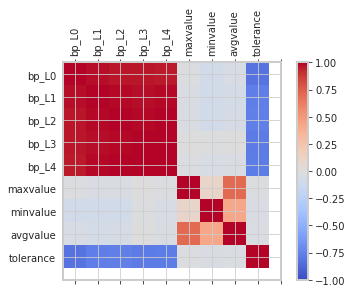

In [ ]:
corr = df_data_corr.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(df_data_corr.columns)+1,1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(df_data_corr.columns)
ax.set_yticklabels(df_data_corr.columns)
plt.show()

In [ ]:
df_data

,timestep,bp_L0,bp_L1,bp_L2,bp_L3,bp_L4,maxvalue,minvalue,avgvalue,tolerance
0,gs1.0.U,13,12,12,10,9,1.000064,0.166475,0.250,0.396371
1,gs1.0.U,14,12,13,10,9,1.000064,0.166475,0.250,0.376483
2,gs1.0.U,14,12,13,10,10,1.000064,0.166475,0.250,0.221081
3,gs1.0.U,14,12,13,10,10,1.000064,0.166475,0.250,0.221081
4,gs1.0.U,14,12,13,11,10,1.000064,0.166475,0.250,0.137550
...,...,...,...,...,...,...,...,...,...,...
27643,gs1.1023.U,32,31,29,25,22,0.938281,0.122947,0.125,-0.174169
27644,gs1.1023.U,32,31,29,25,22,0.938281,0.122947,0.125,-0.174169
27645,gs1.1023.U,32,32,30,26,23,0.938281,0.122947,0.125,-0.174188
27646,gs1.1023.U,32,32,30,26,23,0.938281,0.122947,0.125,-0.174188


In [ ]:
df_data_feature = df_data[["minvalue", "maxvalue", "avgvalue", "tolerance"]].copy()
# df_data_feature = df_data[["minvalue", "avgvalue", "tolerance"]].copy()
# df_data_feature = df_data[["tolerance"]].copy()
df_data_target  = df_data[["bp_L0", "bp_L1", "bp_L2", "bp_L3", "bp_L4"]].copy()

df_data_feature  = np.array(df_data_feature.astype("float32"))
df_data_target = np.array(df_data_target.astype("float32")).reshape(len(df_data["timestep"]), 5)

df_training_feature = df_data_feature[18900:]
df_training_target = df_data_target[18900:]
# df_training_feature = df_data_feature
# df_training_target = df_data_target

X_train, X_test, Y_train, Y_test = train_test_split(df_training_feature, df_training_target, test_size=0.4, shuffle=False, random_state=2)

In [ ]:
np.shape(df_data_target)

(27648, 5)

In [ ]:
np.shape(X_train)

(5248, 4)

In [ ]:
# plt.plot(np.arange(len(X_train)), X_train[:, 0])
# plt.plot(np.arange(len(X_train)), X_train[:, 1])
# plt.plot(np.arange(len(X_train)), X_train[:, 2])

In [ ]:
x_train = Variable(torch.from_numpy(X_train))
y_train = Variable(torch.from_numpy(Y_train))

net = torch.nn.Sequential(
        torch.nn.Linear(4, 16),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(16, 32),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(32, 16),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(16, 5),
        )

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
# loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss
loss_func = torch.nn.L1Loss()

BATCH_SIZE = 64
EPOCH = 300

torch_dataset = Data.TensorDataset(x_train, y_train)

loader = Data.DataLoader(
    dataset=torch_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True, num_workers=2,)

# start training
for epoch in range(EPOCH):
    for step, (batch_x, batch_y) in enumerate(loader): # for each training step

        b_x = Variable(batch_x)
        b_y = Variable(batch_y)

        prediction = net(b_x)     # input x and predict based on x

        loss = loss_func(prediction, b_y)     # must be (1. nn output, 2. target)
        # print(loss)

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    if epoch % 10 == 0:
        print(loss.detach().numpy())

In [ ]:
loss.detach().numpy()

array(0.4499468, dtype=float32)

In [ ]:
# from torchsummary import summary
# summary(net, (BATCH_SIZE, 4))

In [ ]:
# training_loss = [3.833057,2.1723375,1.921458,1.2313327,0.7818446,0.8503435,0.7306534,0.8216917,0.6851417,0.68027574,0.76331306,0.67376053,0.60897434,0.5797195,0.64088243,0.85624313,0.5905499,0.5542273,0.567169,0.47557703,0.8752059,0.4922143,0.60368544,0.56882983,0.6067285,0.7636843,0.5100756,0.56182766,0.60092115,0.6455679]
# fig, axs = plt.subplots(1, 1, figsize=(5, 3))
# axs.plot(np.arange(len(training_loss)), training_loss)
# axs.set_xlabel("Training epochs");
# axs.set_ylabel("Training loss (MAE)");
# axs.set_xticks([0, 5, 10, 15, 20, 25, 30])
# # axs.set_xticklabels([0, 200, 400, 600, 800, 1000])
# axs.set_yticks([0, 1, 2, 3, 4, 5]);

In [ ]:
# np.shape(Y_test)

(1750, 5)

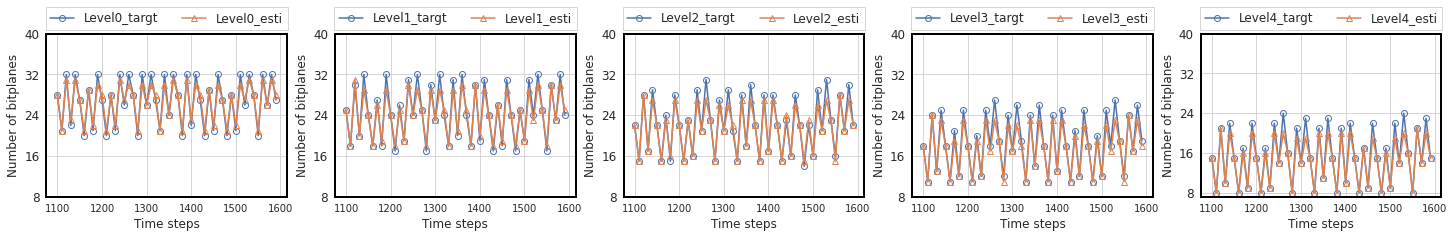

In [ ]:
# Gray-scott.1.U.test
x_test = Variable(torch.from_numpy(X_test))
y_test = Variable(torch.from_numpy(Y_test))
p_test = net(x_test)

fig1, axs1 = plt.subplots(1, 5, figsize=(25, 3))
# fig2, axs2 = plt.subplots(1, 5, figsize=(25, 3))
for level in np.arange(0, 5):
    y = y_test.detach().numpy()[:, level]#[0:200]
    p = p_test.detach().numpy()[:, level]#[0:200]

    axs1[level].plot(np.arange(len(y[3:17500:70])), y[3:17500:70],                label="Level{}_targt".format(level),     marker="o", fillstyle="none", color=current_palette[0], alpha=1)
    axs1[level].plot(np.arange(len(y[3:17500:70])), p.astype(np.int)[3:17500:70], label="Level{}_esti".format(level), marker="^", fillstyle="none", color=current_palette[1], alpha=1)

    # axs1[level].plot(np.arange(len(y)), y,                label="Target_level{}".format(level),     marker="o", fillstyle="none", color=current_palette[0], alpha=.1)
    # axs1[level].plot(np.arange(len(y)), p.astype(np.int), label="Prediction_level{}".format(level), marker="^", fillstyle="none", color=current_palette[1], alpha=.1)
    # axs1[level].set_xticks([0, 20, 40, 60, 80, 100])
    axs1[level].set_xticklabels([1000, 1100, 1200, 1300, 1400, 1500, 1600])
    axs1[level].set_yticks([8, 16, 24, 32, 40])
    axs1[level].set_yticklabels([8, 16, 24, 32, 40], fontsize=12)
    axs1[level].set_xlabel("Time steps", fontsize=12)
    axs1[level].set_ylabel("Number of bitplanes", fontsize=12)
    axs1[level].legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), fancybox=False, shadow=False, ncol=2, fontsize=12)

    axs1[level].spines["bottom"].set_color("black")
    axs1[level].spines["top"].set_color("black")
    axs1[level].spines["right"].set_color("black")
    axs1[level].spines["left"].set_color("black")

# fig1.savefig("/content/drive/MyDrive/Colab Notebooks/HPDC22/demo.pdf", bbox_inches="tight")

## Testing with GS2.U

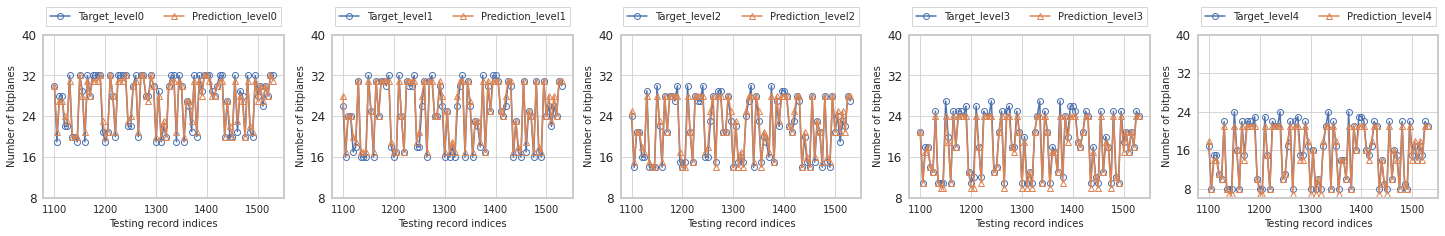

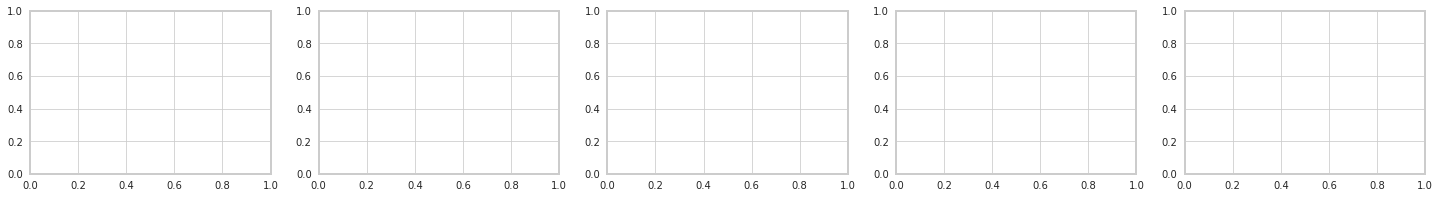

In [ ]:
# Gray-scott results
df_features = pd.read_csv("gs2_f_U_features.csv")

# normalization: (z = x - mean(x))/(max(x) - min(x))
df_data = copy.deepcopy(df_features)
# for col in ["tolerance"]:
#     df_data[col] = (df_data[col] - np.mean(df_data[col]))/(np.max(df_data[col]) - np.min(df_data[col]))
for col in ["tolerance"]:
    df_data[col] = (df_data[col] - norm_mean)/(norm_max - norm_min)

##
df_data_feature = df_data[["minvalue", "maxvalue", "avgvalue", "tolerance"]].copy()
df_data_target  = df_data[["bp_L0", "bp_L1", "bp_L2", "bp_L3", "bp_L4"]].copy()
df_data_feature  = np.array(df_data_feature.astype("float32"))
df_data_target = np.array(df_data_target.astype("float32")).reshape(len(df_data["timestep"]), 5)

df_training_feature = df_data_feature[18900:]
df_training_target = df_data_target[18900:]
# df_training_feature = df_data_feature
# df_training_target = df_data_target


X_train, X_test, Y_train, Y_test = train_test_split(df_training_feature, df_training_target, test_size=0.01, random_state=2)
##

x_test = Variable(torch.from_numpy(X_train))
y_test = Variable(torch.from_numpy(Y_train))
p_test = net(x_test)

fig, axs1 = plt.subplots(1, 5, figsize=(25, 3))
fig, axs2 = plt.subplots(1, 5, figsize=(25, 3))
for level in np.arange(0, 5):
    y = y_test.detach().numpy()[:, level]
    p = p_test.detach().numpy()[:, level]

    axs1[level].plot(np.arange(len(y[0:8660:100])), y[0:8660:100],                label="Target_level{}".format(level),     marker="o", fillstyle="none", color=current_palette[0], alpha=1)
    axs1[level].plot(np.arange(len(y[0:8660:100])), p.astype(np.int)[0:8660:100], label="Prediction_level{}".format(level), marker="^", fillstyle="none", color=current_palette[1], alpha=1)

    # axs1[level].plot(np.arange(len(y)), y,                label="Target_level{}".format(level),     marker="o", fillstyle="none", color=current_palette[0], alpha=1)
    # axs1[level].plot(np.arange(len(y)), p.astype(np.int), label="Prediction_level{}".format(level), marker="^", fillstyle="none", color=current_palette[1], alpha=1)
    # axs1[level].set_yticks([6, 12, 18, 24, 30, 36])
    axs1[level].set_xticklabels([1000, 1100, 1200, 1300, 1400, 1500])
    axs1[level].set_yticks([8, 16, 24, 32, 40])
    axs1[level].set_yticklabels([8, 16, 24, 32, 40], fontsize=12)
    axs1[level].set_xlabel("Testing record indices")
    axs1[level].set_ylabel("Number of bitplanes")
    axs1[level].legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), fancybox=False, shadow=False, ncol=2)

    # # histogram
    # # hist, bin_edges = np.histogram((y - p.astype(np.int)), bins=np.arange(np.min((y - p.astype(np.int))), np.max(y - p.astype(np.int))+2, 1), density=True)
    # hist, bin_edges = np.histogram((y - p.astype(np.int)), bins=np.arange(-5, 7, 1), density=True)
    # axs2[level].bar(np.arange(len(hist)), hist, align="center")
    # axs2[level].plot(np.arange(len(hist)), np.cumsum(hist), color="tab:red")
    # axs2[level].set_xticks(np.arange(len(hist)))
    # axs2[level].set_yticks([.0, .2, .4, .6, .8, 1])
    # axs2[level].set_yticklabels([0, 20, 40, 60, 80, 100])
    # axs2[level].set_xticklabels(bin_edges, rotation=40)
    # axs2[level].set_xlabel("Absolute estimation error")
    # axs2[level].set_ylabel("Percentage of testing records (%)")


In [ ]:
np.shape(Y_train)

(8660, 5)

## Error bound optimization

In [ ]:
lambda_0 = -2 + np.sqrt(3)
lambda_1 = -2 - np.sqrt(3)

delta_0 = np.absolute(lambda_0)
delta_1 = np.absolute(lambda_1)

def cosh_delta(n):
    return 1/2 * (np.power(delta_1, n) + np.power(delta_0, n))

def sinh_delta(n):
    return 1/2 * (np.power(delta_1, n) - np.power(delta_0, n))


In [ ]:
def func_c(y, N):
    yL = y
    yR = N - y
    return 3/2 * (cosh_delta(N) + cosh_delta(yR - yL) - cosh_delta(yR) - cosh_delta(yL))/(sinh_delta(N)*sinh_delta(1))


In [ ]:
# y_error_e =

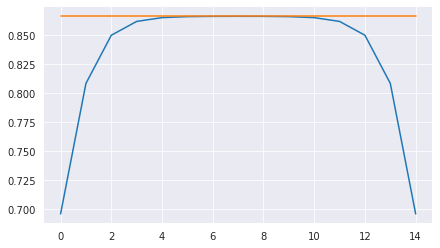

In [ ]:
N = 16
y = np.arange(1, N)
y_error = func_c(y, N)

fig1, axs1 = plt.subplots(1, 1, figsize=(7, 4))
axs1.plot(np.arange(len(y_error)), y_error)
axs1.plot(np.arange(len(y_error)), [np.sqrt(3)/2]*len(y_error))
# axs1.plot(np.arange(len(y_error)), [np.sqrt(3)/2]*len(y_error))

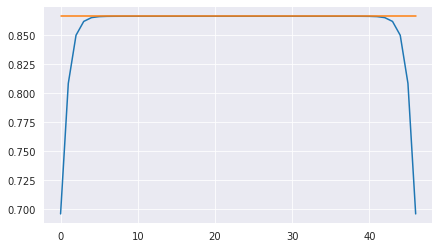

In [ ]:
N = 48
y = np.arange(1, N)
y_error = func_c(y, N)

fig1, axs1 = plt.subplots(1, 1, figsize=(7, 4))
axs1.plot(np.arange(len(y_error)), y_error)
axs1.plot(np.arange(len(y_error)), [np.sqrt(3)/2]*len(y_error))



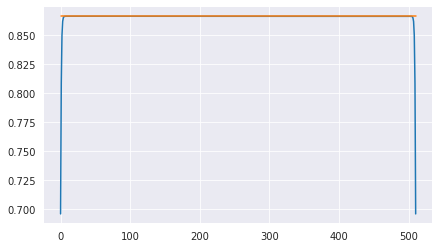

In [ ]:
N = 512
y = np.arange(1, N)
y_error = func_c(y, N)

fig1, axs1 = plt.subplots(1, 1, figsize=(7, 4))
axs1.plot(np.arange(len(y_error)), y_error)
axs1.plot(np.arange(len(y_error)), [np.sqrt(3)/2]*len(y_error))



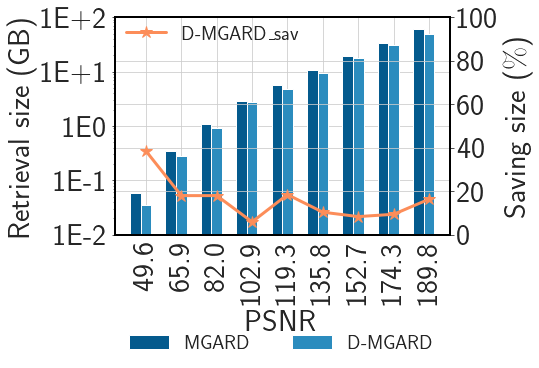

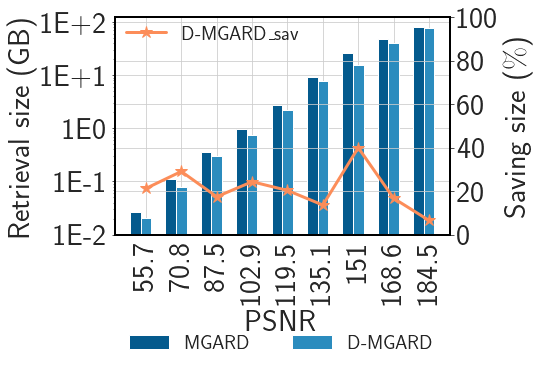

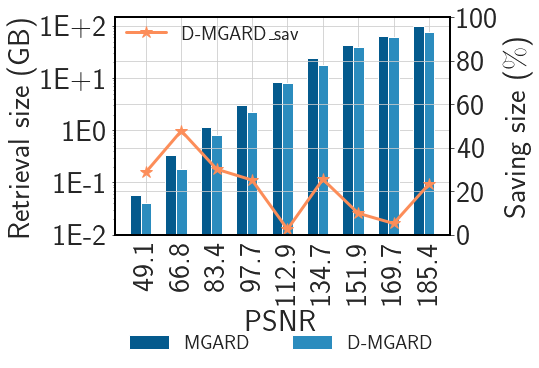

In [ ]:
# emagrd
fontsize = 30
def plot_retrieve_size(mgard, dmgard, emgard, sav_dmgard, sav_emgard, PSNR, t_step):
    plt.rcParams['text.usetex'] = True
    fig2, axs1 = plt.subplots(1, 1, figsize=(6, 4))

    # axs1.plot(np.arange(9), mgard, "-*", color="#0571b0", linewidth=3, markersize=12, label="MGARD")
    # axs1.plot(np.arange(9), dmgard, "-*", color="#0571b0", linewidth=3, markersize=12, label="D-MGARD")
    # axs1.plot(np.arange(9), emgard, "-*", color="#ca0020", linewidth=3, markersize=12, label="E-MGARD")
    axs1.bar(np.arange(9),     mgard, color="#045a8d", width=.3, label="MGARD")
    axs1.bar(np.arange(9)+.3, dmgard, color="#2b8cbe", width=.3, label="D-MGARD")
    # axs1.bar(np.arange(9)+.6, emgard, color="#74a9cf", width=.3, label="E-MGARD")

    axs1.set_xticks(np.arange(9)+.3)
    axs1.set_xticklabels(PSNR, fontsize=fontsize, rotation=90)

    # y: size
    axs1.set_yscale("log")
    axs1.set_yticks([.01, .1, 1, 10, 100])
    axs1.set_yticklabels(["1E-2", "1E-1", "1E0", "1E+1", "1E+2"], fontsize=fontsize)

    axs1.set_xlabel(r"PSNR", fontsize=fontsize)
    axs1.set_ylabel(r"Retrieval size (GB)", fontsize=fontsize)

    axs1.legend(frameon=False, ncol=2, bbox_to_anchor=(.5, -.5), loc='center', fontsize=20)

    axs2 = axs1.twinx()
    # axs2.plot(np.arange(9)+.3, sav_emgard, "-*", color="#e34a33", linewidth=3, markersize=12, label="E-MGARD\_sav")
    axs2.plot(np.arange(9)+.3, sav_dmgard, "-*", color="#fc8d59", linewidth=3, markersize=12, label="D-MGARD\_sav")
    axs2.set_yticks([0, .2, .4, .6, .8, 1.0])
    axs2.set_yticklabels([0, 20, 40, 60, 80, 100], fontsize=fontsize)
    axs2.set_ylabel(r"Saving size ($\%$)", fontsize=fontsize)

    # axs2.legend(frameon=False, ncol=2, bbox_to_anchor=(.5, -.7), loc='center', fontsize=30)
    axs2.legend(loc='upper left', bbox_to_anchor=(-0.02, 1.05), fancybox=False, shadow=False, frameon=False, ncol=1, fontsize=20)

    axs2.spines["bottom"].set_color("black")
    axs2.spines["top"].set_color("black")
    axs2.spines["right"].set_color("black")
    axs2.spines["left"].set_color("black")

    plt.savefig("retrieve_size_t{}_presentation.pdf".format(t_step), bbox_inches="tight")

for t in [4, 16, 32]:
    if t == 4:
        # t = 4
        # retrieval size
        emgard = np.array([0.041479111, 0.369317055, 1.299512863, 3.492879868, 7.401013374, 14.85336208, 31.13661861, 50.75330067, 77.94738197])*512/1024
        dmgard = np.array([0.071479111, 0.569317055, 1.799512863, 5.492879868, 9.401013374, 18.85336208, 35.13661861, 61.75330067, 99.94738197])*512/1024
        mgard = np.array([0.116218567, 0.693799019, 2.193156242, 5.835487366, 11.52219677, 21.02412033, 38.31849766, 68.13296032, 119.4137554])*512/1024
        sav_dmgard = (mgard - dmgard)/mgard
        sav_emgard = (mgard - emgard)/mgard
        PSNR = [49.6, 65.9, 82.0, 102.9, 119.3, 135.8, 152.7, 174.3, 189.8]

    if t == 16:
        # t = 16
        # retrieval size
        emgard = np.array([0.012905121, 0.113607407, 0.386996269, 1.329825401, 3.161617279, 8.740805626, 28.06813622, 79.49196625, 121.8455648])*525/1024
        dmgard = np.array([0.041479111, 0.1569317055, 0.599512863, 1.492879868, 4.401013374, 15.85336208, 31.13661861, 79.75330067, 151.94738197])*512/1024 #
        mgard = np.array([0.052671432, 0.221222878, 0.7260952, 1.972993851, 5.524234772, 18.35130692, 51.88391399, 95.74493599, 162.5797443])*512/1024
        sav_emgard = (mgard - emgard)/mgard
        sav_dmgard = (mgard - dmgard)/mgard
        PSNR = [55.7, 70.8, 87.5, 102.9, 119.5, 135.1, 151, 168.6, 184.5, 184.5]

    if t == 32:
        # t = 32
        # retrieval size
        emgard = np.array([0.03456974, 0.265130997, 1.161890984, 3.528425217, 11.26103687, 27.99983406, 59.45767784, 100.957531, 156.2970219])*511/1024
        dmgard = np.array([0.081479111, 0.3569317055, 1.599512863, 4.492879868, 16.401013374, 35.85336208, 77.13661861, 121.75330067, 151.94738197])*512/1024 #
        mgard = np.array([0.114098549, 0.681836128, 2.28396225, 5.985458374, 16.78324318, 47.99290371, 85.37001419, 128.0941238, 197.6535254])*513/1024
        sav_emgard = (mgard - emgard)/mgard
        sav_dmgard = (mgard - dmgard)/mgard

        PSNR = [49.1, 66.8, 83.4, 97.7, 112.9, 134.7, 151.9, 169.7, 185.4]

    plot_retrieve_size(mgard, dmgard, emgard, sav_dmgard, sav_emgard, PSNR, t)

In [ ]:
pwd

'/content/drive/MyDrive/Colab Notebooks/HPDC22'

In [ ]:
ls

archive/               expr_20211121/  expr_20220310/
CAE-FE/                expr_20211224/  expr_20220502/
data_range.xlsx        expr_20220113/  migrate_from_dropbpx/
error_estimation.xlsx  expr_20220124/  motivation/
expr_20211116/         expr_20220125/  notebooks/
expr_20211117/         expr_20220201/  opencv-python-color-detection/
expr_20211118/         expr_20220223/


In [ ]:
# fontsize = 30
# def plot_achieved_error(input_error, mgard_error, emgard_error, PSNR, t_step):
#     plt.rcParams['text.usetex'] = True
#     fig2, axs1 = plt.subplots(1, 1, figsize=(6, 4))

#     axs1.plot(np.arange(9), input_error, "-*", color="#0571b0", linewidth=3, markersize=12, label="Input error")
#     axs1.plot(np.arange(9), mgard_error, "-*", color="#ef8a62", linewidth=3, markersize=12, label="MGARD achieved error")
#     axs1.plot(np.arange(9), emgard_error, "-*", color="#ca0020", linewidth=3, markersize=12, label="E-MGARD achieved error")

#     axs1.set_xticks(np.arange(9))
#     axs1.set_xticklabels( PSNR, fontsize=fontsize, rotation=90)

#     # y: size
#     axs1.set_yscale("log")
#     axs1.set_yticks([1e-5, 1e-3, 1e-1, 1e1, 1e3, 1e5])
#     if t_step == 4:
#         axs1.set_yticklabels(["1E-5", "1E-3", "1E-1", "1E+1", "1E+3", "1E+5"], fontsize=fontsize)
#     if t_step == 16:
#         axs1.set_yticklabels(["1E-11", "1E-7", "1E-3", "1E+3", "1E+7", "1E+11"], fontsize=fontsize)
#     if t_step == 32:
#         axs1.set_yticklabels(["1E-13", "1E-8", "1E-3", "1E+3", "1E+8", "1E+13"], fontsize=fontsize)

#     axs1.set_xlabel(r"PSNR", fontsize=fontsize)
#     axs1.set_ylabel(r"Maximum absolute error", fontsize=25)

#     # axs1.legend(frameon=False, ncol=3, bbox_to_anchor=(.5, -.5), loc='center', fontsize=30)
#     axs1.legend(loc='lower left', bbox_to_anchor=(0, 0), fancybox=False, shadow=False, frameon=False, ncol=1, fontsize=18)

#     axs1.spines["bottom"].set_color("black")
#     axs1.spines["top"].set_color("black")
#     axs1.spines["right"].set_color("black")
#     axs1.spines["left"].set_color("black")

#     # plt.savefig("achieved_error_t{}.pdf".format(t_step), bbox_inches="tight")

# for t in [4, 16, 32]:
#     if t == 4:
#         # t = 4
#         input_error = np.array([55109.81 ,5510.981 ,551.0981 ,55.10981 ,5.510981 ,0.5510981 ,0.05510981 ,0.005510981 ,0.000551098])
#         mgard_error = np.array([3974.12438, 416.67513, 49.66038, 3.949, 0.47257, 0.06462, 0.00665, 0.00048, 0.00011])
#         emgard_error =np.array([13745.35635, 1006.61133, 142.55305, 14.67507, 1.89627, 0.21195, 0.01454, 0.00185, 0.00025])
#         PSNR = [41.9, 59.2, 74.7, 92.1, 108.3, 125.2, 147.2, 163.4, 179.6]

#     if t == 16:
#         # t = 16
#         input_error = np.array([68713.54 ,6871.354 ,687.1354 ,68.71354 ,6.871354 ,0.6871354 ,0.06871354 ,0.006871354 ,0.000687135])
#         mgard_error = np.array([3862.72659, 490.76129, 55.96871, 6.78255, 0.61843, 0.06875, 0.00721, 0.0009, 0.00023])
#         emgard_error =np.array([13068.62352, 1609.62558, 217.26464, 13.86827, 1.83052, 0.55756, 0.06657, 0.00192, 0.00035])
#         PSNR = [47.3, 62.6, 77.3, 97.5, 111.6, 125.5, 140.3, 162.6, 179.9]

#     if t == 32:
#         # t = 32
#         input_error = np.array([39612.01, 3961.201, 396.1201, 39.61201, 3.961201, 0.3961201, 0.03961201, 0.003961201, 0.00039612])
#         mgard_error = np.array([3041.37163, 267.5618, 27.91513, 3.64494, 0.42157, 0.02768, 0.0038, 0.00049, 0.00012])
#         emgard_error = np.array([7276.87159, 969.25242, 111.00797, 13.25765, 0.92812, 0.12408, 0.01399, 0.00174, 0.00018])
#         PSNR = [42.8, 56.9, 73.4, 88.8, 107.5, 123.2, 140.3, 157.9, 180.3]

#     plot_achieved_error(input_error, mgard_error, emgard_error, PSNR, t)

In [ ]:
fontsize = 30

input_error_bx = [35700,31700,27700,23800,19800,15800,11900,7920,3960,
                  3570,3170,2770,2380,1980,1580,1190,792,396,
                  357,317,277,238,198,158,119,79.2,
                  39.6,35.7,31.7,27.7,23.8,19.8,15.8,11.9,
                  7.92,3.96,3.57,3.17,2.77,2.38,1.98,1.58,
                  1.19,0.792,0.396,0.357,0.317,0.277,0.238,
                  0.198,0.158,0.119,0.0792,0.0396,0.0357,0.0317,
                  0.0277,0.0238,0.0198,0.0158,0.0119,0.00792,
                  0.00396,0.00357,0.00317,0.00277,0.00238,0.00198,
                  0.00158,0.00119,0.000792]

predicted_error_bx_t4 = [26446.3,26446.3,26446.3,18902.9,18902.9,13223.2,9451.46,6611.59,3128.3,3128.3,3128.3,
                      2373.96,2373.96,1541.96,1541.96,1186.98,770.982,302.292,302.292,302.292,195.519,
                      195.519,195.519,151.146,80.7728,75.2262,36.9198,30.8965,30.8965,18.4166,18.4166,18.4166,
                      14.7549,9.12161,7.33412,3.66435,3.56685,2.1802,2.1802,2.1802,1.83218,1.08942,
                      1.08942,0.458044,0.222928,0.222928,0.222928,0.222928,0.222928,0.111422,0.111422,0.111422,
                      0.0557109,0.0278555,0.0278555,0.0278555,0.0251471,0.0139277,0.0139277,0.0139277,0.00696387,0.00696387,
                      0.00349251,0.00349251,0.00315397,0.0017575,0.0017575,0.0017575,0.00108042,0.00108042,0.000741878,]

predicted_error_bx_t8 = [31459.6,31459.6,22486.2,22486.2,15729.8,15729.8,11243.1,7864.91,3932.45,2810.78,2810.78,
                  1966.23,1966.23,1966.23,1411.99,930.329,705.994,352.997,352.997,229.283,229.283,229.283,
                  176.499,142.683,89.8988,58.1455,37.2173,24.0211,24.0211,24.0211,22.3716,18.4024,11.8044,
                  11.8044,5.47692,2.71269,2.71269,2.71269,2.71269,2.1811,1.35473,1.35473,1.08975,0.648371,
                  0.323984,0.323984,0.272436,0.272436,0.136218,0.136218,0.136218,0.118046,0.0662969,0.0331359,0.0331359,
                  0.0299141,0.0165679,0.0165679,0.0165679,0.0149571,0.00828397,0.00747854,0.00373927,0.00207099,0.00207099,0.00207099,
                  0.00207099,0.00186963,0.00103864,0.00103864,0.000522664,]

predicted_error_bx_t16 = [14244.6778,13581.49074,10251.61678,8679.89715,13274.08313,13197.28203,
                      7276.87159,6979.90867,3041.37163,3041.37163,1915.69065,1915.69065,
                      1931.69065,1780.94519,969.25242,956.49769,479.25905,257.96787,
                      257.96787,257.96787,202.69299,202.69299,132.11235,132.11235,
                      111.00797,73.25113,27.91513,27.91513,27.91513,27.91513,
                      18.51275,18.51275,14.70194,13.25765,7.35565,3.70043,
                      3.64494,3.29836,3.29478,1.96585,1.96585,1.67065,
                      0.92812,0.91437,0.49378,0.42157,0.24946,0.24946,
                      0.24946,0.24946,0.12408,0.12408,0.10807,0.05288,
                      0.02768,0.02768,0.02768,0.02768,0.02771,0.01399,
                      0.01399,0.00727,0.0038,0.0038,0.0038,0.0038,
                      0.0036,0.00191,0.00191,0.00174]

achieved_error_bx_t4 = [1915.69065,1915.69065,1915.69065,1780.94519,1780.94519,969.25242,795.71668,479.25905,257.96787,257.96787,257.96787,
                     202.69299,202.69299,132.11235,132.11235,111.00797,73.25113,27.91513,27.91513,27.91513,18.51275,18.51275,
                     18.51275,14.70194,7.35565,7.15062,3.64494,3.29836,3.29836,1.96585,1.96585,1.96585,1.67065,
                     0.92812,0.89131,0.42157,0.41944,0.24946,0.24946,0.24946,0.23336,0.12408,0.12408,0.05498,
                     0.02768,0.02768,0.02768,0.02768,0.02768,0.01399,0.01399,0.01399,0.00727,0.0038,0.0038,0.0038,
                     0.0036,0.00191,0.00191,0.00191,0.00092,0.00092,0.00049,0.00049,0.00045,0.00027,0.00027,0.00027,0.00018,0.00018,0.00013,]

achieved_error_bx_t8 = [7276.87159,7276.87159,6979.90867,6979.90867,3665.87842,3665.87842,3041.37163,1915.69065,969.25242,795.71668,795.71668,479.25905,479.25905,479.25905,410.03493,257.96787,202.69299,111.00797,111.00797,73.25113,73.25113,73.25113,55.23448,48.13443,27.91513,18.51275,13.25765,7.35565,7.35565,7.35565,7.15062,6.67018,3.70043,3.70043,1.96585,0.92812,0.92812,0.92812,0.92812,0.89131,0.48609,0.48609,0.42157,0.24946,0.12408,0.12408,0.11262,0.11262,0.05498,0.05498,0.05498,0.05299,0.02768,0.01399,0.01399,0.01378,0.00727,0.00727,0.00727,0.00663,0.00380,0.00360,0.00174,0.00092,0.00092,0.00092,0.00092,0.00086,0.00049,0.00049,0.00027]

achieved_error_bx_t16 = [13197.28203,13197.28203,13229.00220,7276.87159,7276.87159,6979.90867,3665.87842,3041.37163,1780.94519,1780.94519,969.25242,969.25242,956.49769,795.71668,479.25905,473.08846,257.96787,132.11235,132.11235,132.11235,111.00797,111.00797,73.25113,73.25113,55.23448,27.91513,18.51275,18.51275,14.70194,14.70194,13.25765,7.35565,7.35565,6.67018,3.70043,1.96585,1.96585,1.92187,1.67065,0.92812,0.92812,0.91817,0.48609,0.49378,0.24946,0.23336,0.12408,0.12408,0.12408,0.12408,0.10807,0.05498,0.05288,0.02771,0.01399,0.01399,0.01399,0.01399,0.01378,0.00727,0.00727,0.00380,0.00191,0.00191,0.00191,0.00191,0.00174,0.00092,0.00092,0.00086,0.00049]


psnr_bx_t4 = [51.87,51.87,51.87,53.75,53.75,56.91,
           58.59,61.83,66.93,66.93,66.93,68.44,
           68.44,71.98,71.98,73.44,76.98,83.38,
           83.38,83.38,86.61,86.61,86.61,88.15,
           92.84,92.96,97.71,98.33,98.33,102.53,
           102.53,102.53,103.22,107.54,108.15,112.96,
           112.97,117.63,117.63,117.63,118.05,123.2,
           123.2,129.25,134.78,134.78,134.78,134.78,
           134.78,140.35,140.35,140.35,146.12,151.97,
           151.97,151.97,152.05,157.83,157.83,157.83,
           163.79,163.79,169.69,169.69,169.77,175.47,
           175.47,175.47,180.32,180.32,183.61,]

psnr_bx_t8 = [42.81,42.81,44.23,44.23,47.15,47.15,49.11,51.87,56.91,58.59,58.59,
           61.83,61.83,61.83,63.56,66.93,68.44,73.44,73.44,76.98,76.98,76.98,
           78.45,79.13,83.38,86.61,88.85,92.84,92.84,92.84,92.96,93.60,97.58,
           97.58,102.53,107.54,107.54,107.54,107.54,108.15,112.46,112.46,112.96,117.63,
           123.20,123.20,123.61,123.61,129.25,129.25,129.25,129.37,134.78,140.35,140.35,140.44,
           146.12,146.12,146.12,146.21,151.97,152.05,157.91,163.79,163.79,163.79,163.79,163.87,169.69,169.69,175.47,180.32,180.32,183.61,183.61,183.61,184.96,185.43]

psnr_bx_t16 = [39.83,39.83,39.84,42.81,42.81,44.23,47.15,49.11,53.75,53.75,56.91,56.91,56.91,58.59,61.83,61.90,66.93,71.98,71.98,71.98,73.44,73.44,76.98,76.98,78.45,83.38,86.61,86.61,88.15,88.15,88.85,92.84,92.84,93.60,97.58,102.53,102.53,102.58,103.22,107.54,107.54,107.58,112.46,112.49,117.63,118.05,123.20,123.20,123.20,123.20,123.73,129.25,129.37,134.87,140.35,140.35,140.35,140.35,140.44,146.12,146.12,151.97,157.83,157.83,157.83,157.83,157.91,163.79,163.79,163.87,169.69]


def plot_achieved_error(input_error, mgard_error, emgard_error, psnr):
    plt.rcParams['text.usetex'] = True
    fig2, axs1 = plt.subplots(1, 1, figsize=(6, 4))

    axs1.plot(np.arange(len(input_error[2:-1:4])), input_error[2:-1:4], "-*", color="#0571b0", linewidth=3, markersize=12, label="Input error")
    axs1.plot(np.arange(len(mgard_error[2:-1:4])), np.array(mgard_error[2:-1:4])/4.5, "-*", color="#ef8a62", linewidth=3, markersize=12, label="MGARD achieved error")
    axs1.plot(np.arange(len(emgard_error[2:-1:4])), np.array(emgard_error[2:-1:4])/2.2, "-*", color="#ca0020", linewidth=3, markersize=12, label="E-MGARD achieved error")

    # print(input_error[2:-1:4])
    # print(np.array(emgard_error[2:-1:4])/2.2)

    axs1.set_xticks(np.arange(len(psnr[2:-1:4])),psnr[2:-1:4])
    axs1.set_xticklabels(psnr[2:-1:4], fontsize=fontsize, rotation=90)

    axs1.set_yscale("log")
    axs1.set_yticks([1e-5, 1e-3, 1e-1, 1e1, 1e3, 1e5])
    axs1.set_yticklabels(["1E-5", "1E-3", "1E-1", "1E+1", "1E+3", "1E+5"], fontsize=fontsize)

    axs1.set_xlabel(r"PSNR", fontsize=fontsize)
    axs1.set_ylabel(r"Maximum absolute error", fontsize=25)
    axs1.legend(loc='lower left', bbox_to_anchor=(0, 0), fancybox=False, shadow=False, frameon=False, ncol=1, fontsize=18)

    axs1.spines["bottom"].set_color("black")
    axs1.spines["top"].set_color("black")
    axs1.spines["right"].set_color("black")
    axs1.spines["left"].set_color("black")

plot_achieved_error(input_error_bx, achieved_error_bx_t4, predicted_error_bx_t4, psnr_bx_t4)
# plt.savefig("emgard_bx_4.pdf", bbox_inches="tight")

plot_achieved_error(input_error_bx, achieved_error_bx_t8, predicted_error_bx_t8, psnr_bx_t8)
# plt.savefig("emgard_bx_8.pdf", bbox_inches="tight")

plot_achieved_error(input_error_bx, achieved_error_bx_t16, predicted_error_bx_t16, psnr_bx_t16)
# plt.savefig("emgard_bx_16.pdf", bbox_inches="tight")

73 73
[26500000000.0, 14700000000.0, 2940000000.0, 1770000000.0, 589000000.0, 206000000.0, 88300000.0, 23600000.0, 11800000.0, 2650000.0, 1470000.0, 294000, 177000, 58900, 20600, 8830, 2360, 1180]
[9.240000e+09 5.800000e+09 1.088000e+09 6.920000e+08 1.700000e+08
 6.120000e+07 2.928000e+07 6.160000e+06 2.992000e+06 7.480000e+05
 3.738696e+05 9.346760e+04 4.675160e+04 2.339348e+04 5.875000e+03
 2.964120e+03 7.809640e+02 4.259800e+02]
[26500000000.0, 14700000000.0, 2940000000.0, 1770000000.0, 589000000.0, 206000000.0, 88300000.0, 23600000.0, 11800000.0, 2650000.0, 1470000.0, 294000, 177000, 58900, 20600, 8830, 2360, 1180]
[8.720000e+09 5.800000e+09 9.520000e+08 6.520000e+08 2.284000e+08
 7.920000e+07 3.500000e+07 8.720000e+06 3.656000e+06 8.880000e+05
 4.440000e+05 1.111856e+05 5.559280e+04 1.390348e+04 6.957000e+03
 3.483784e+03 1.281504e+03 8.486680e+02]
[26500000000.0, 14700000000.0, 2940000000.0, 1770000000.0, 589000000.0, 206000000.0, 88300000.0, 23600000.0, 11800000.0, 2650000.0, 14

<ipython-input-8-4ab99bc74739>:35: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs1.set_xticks(np.arange(len(psnr[0:-1:4])),psnr[0:-1:4])
<ipython-input-8-4ab99bc74739>:35: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs1.set_xticks(np.arange(len(psnr[0:-1:4])),psnr[0:-1:4])
<ipython-input-8-4ab99bc74739>:35: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs1.set_xticks(np.arange(len(psnr[0:-1:4])),psnr[0:-1:4])


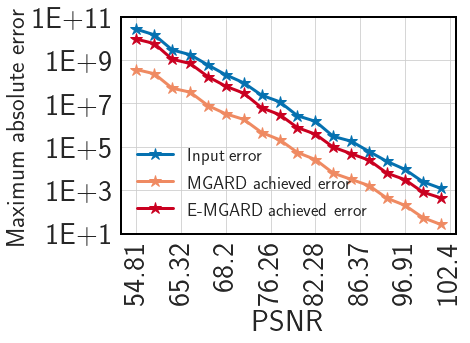

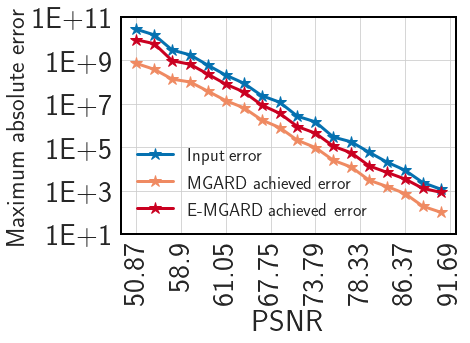

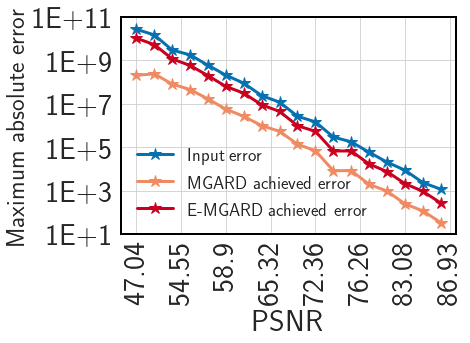

In [ ]:
fontsize = 30

input_error_ex = [2.65E+10,2.36E+10,2.06E+10,1.77E+10,1.47E+10,1.18E+10,8.83E+09,5.89E+09,2.94E+09,2.65E+09,2.36E+09,2.06E+09,1.77E+09,1.47E+09,1.18E+09,8.83E+08,5.89E+08,2.94E+08,2.65E+08,2.36E+08,2.06E+08,1.77E+08,1.47E+08,1.18E+08,8.83E+07,5.89E+07,2.94E+07,2.65E+07,2.36E+07,2.06E+07,1.77E+07,1.47E+07,1.18E+07,8.83E+06,5.89E+06,2.94E+06,2.65E+06,2.36E+06,2.06E+06,1.77E+06,1.47E+06,1.18E+06,883000,589000,294000,265000,236000,206000,177000,147000,118000,88300,58900,29400,26500,23600,20600,17700,14700,11800,8830,5890,2940,2650,2360,2060,1770,1470,1180,883,589,294,265]

predicted_error_ex_t4 = [2.31E+10,2.31E+10,1.71E+10,1.71E+10,1.45E+10,1.10E+10,8.00E+09,5.49E+09,2.72E+09,1.92E+09,1.92E+09,1.92E+09,1.73E+09,1.36E+09,8.64E+08,8.64E+08,4.25E+08,2.93E+08,2.46E+08,1.53E+08,1.53E+08,1.53E+08,1.46E+08,7.32E+07,7.32E+07,5.40E+07,2.70E+07,1.54E+07,1.54E+07,1.54E+07,1.54E+07,1.35E+07,7.48E+06,7.48E+06,3.74E+06,1.87E+06,1.87E+06,1.87E+06,1.87E+06,1.69E+06,934674,934674,843798,467337,233669,233669,233669,116879,116879,116879,116879,58483.7,58483.7,29286.2,26446.3,14687.5,14687.5,14687.5,14687.5,7410.3,7410.3,3771.71,1952.41,1952.41,1952.41,1952.41,1064.95,1064.95,1064.95,621.223,576.85,266.238,244.052]

predicted_error_ex_t8 = [2.18E+10,2.18E+10,2.05E+10,1.52E+10,1.45E+10,1.18E+10,8.74E+09,5.09E+09,2.38E+09,2.38E+09,2.35E+09,1.63E+09,1.63E+09,1.18E+09,1.18E+09,8.09E+08,5.71E+08,2.57E+08,2.57E+08,1.98E+08,1.98E+08,1.26E+08,1.26E+08,9.19E+07,8.75E+07,4.55E+07,2.18E+07,2.18E+07,2.18E+07,1.83E+07,1.61E+07,9.14E+06,9.14E+06,8.03E+06,4.57E+06,2.22E+06,2.22E+06,2.22E+06,2.01E+06,1.11E+06,1.11E+06,1.11E+06,556139,556139,277964,250938,138982,138982,138982,138982,69490.9,69490.9,34758.7,17392.5,17392.5,17392.5,17392.5,17392.5,8709.46,8709.46,8709.46,4367.93,2203.76,3203.76,3203.76,1992.62,2121.67, 2121.67,2121.67,1121.67,1121.67,1121.67,1121.67]

predicted_error_ex_t16 = [2.57E+10,2.24E+10,1.91E+10,1.75E+10,1.32E+10,1.14E+10,8.81E+09,5.64E+09,2.89E+09,2.62E+09,1.98E+09,1.98E+09,1.44E+09,1.44E+09,9.90E+08,7.13E+08,4.91E+08,2.45E+08,2.45E+08,2.23E+08,1.56E+08,1.56E+08,1.20E+08,1.11E+08,7.67E+07,5.57E+07,2.76E+07,2.64E+07,2.22E+07,1.32E+07,1.32E+07,1.32E+07,1.11E+07,5.54E+06,5.54E+06,2.77E+06,2.43E+06,1.35E+06,1.35E+06,1.35E+06,1.35E+06,674304,674304,337152,168512,168512,168512,168512,168512,84256,84256,84256,42128,21072,21072,21072,19024,10544,10544,10544,5280,5280,2648,2648,2360,1336,1336,1336,680,680,352,192,192]

achieved_error_ex_t4 = [1812561160,1812561160,1238611027,1238611027,1167878354,935663567.6,677065565.7,500821439.2,249072233.8,188430519.5,188430519.5,188430519.5,163925868.6,127735939.7,85018110.15,85018110.15,39215629.31,32581267.23,28643461.29,16237125.43,16237125.43,16237125.43,15852655.92,8998995.028,8998995.028,7719468.237,3795442.914,2218391.587,2218391.587,2218391.587,2218391.587,2050716.36,1038019.476,1038019.476,483962.6286,265153.0351,265153.0351,265153.0351,265153.0351,245417.979,125315.5473,125315.5473,114168.5326,61434.77691,29441.92343,29441.92343,29441.92343,15198.86376,15198.86376,15198.86376,15198.86376,7808.74637,7808.74637,3715.31883,3802.82031,2035.14303,2035.14303,2035.14303,2035.14303,963.0075,963.0075,513.54638,260.14435,260.14435,260.14435,260.14435,125.47273,125.47273,125.47273,74.51643,73.81478,37.49168,37.02101]

achieved_error_ex_t8 = [3558172976,3558172976,3650537424,1982397805,1916193057,1367570581,1016569457,1238611027,677065565.7,677065565.7,690254685.7,500821439.2,500821439.2,329445285.9,329445285.9,249072233.8,188430519.5,85018110.15,85018110.15,69139137.2,69139137.2,39215629.31,39215629.31,32194270.65,32573815.58,16237125.43,8998995.028,8998995.028,8998995.028,8094103.568,7719468.237,4025982.63,4025982.63,3795442.914,2218391.587,1038019.476,1038019.476,1038019.476,1000216.523,483962.6286,483962.6286,483962.6286,265153.0351,265153.0351,125315.5473,114168.5326,61434.77691,61434.77691,61434.77691,61434.77691,29441.92343,29441.92343,15198.86376,7808.74637,7808.74637,7808.74637,7808.74637,7808.74637,3715.31883,3715.31883,3715.31883,2035.14303,963.0075,963.0075,963.0075,887.67009,513.54638,513.54638,513.54638,260.14435,260.14435,123.72356,74.51643]

achieved_error_ex_t16 = [3054004468,6312674698,6311222913,6199861698,3558172976,3474671951,1916193057,1074881122,1208348585,1167878354,935663567.6,935663567.6,677065565.7,677065565.7,500821439.2,329445285.9,249072233.8,127735939.7,127735939.7,121041074.5,85018110.15,85018110.15,69139137.2,67361424.89,39215629.31,32194270.65,16237125.43,15852655.92,14781505.75,8998995.028,8998995.028,8998995.028,8094103.568,4025982.63,4025982.63,2218391.587,2050716.36,1038019.476,1038019.476,1038019.476,1038019.476,483962.6286,483962.6286,265153.0351,125315.5473,125315.5473,125315.5473,125315.5473,125315.5473,61434.77691,61434.77691,61434.77691,29441.92343,15198.86376,15198.86376,15198.86376,14430.38608,7808.74637,7808.74637,7808.74637,3715.31883,3715.31883,2035.14303,2035.14303,1785.72012,963.0075,963.0075,963.0075,513.54638,513.54638,260.14435,125.47273,125.47273]
achieved_error_ex_t16 = np.array(achieved_error_ex_t16)/3

psnr_ex_t4 = [51.65,51.65,53.93,53.93,54.81,56.95,58.9,61.05,65.32,67.75,67.75,67.75,68.2,69.57,72.36,72.36,76.26,78.33,79.33,82.28,82.28,82.28,82.32,86.37,86.37,87.11,91.83,96.91,96.91,96.91,96.91,97.03,102.4,102.4,108.03,113.77,113.77,113.77,113.77,113.86,119.59,119.59,119.68,125.38,131.15,131.15,131.15,136.98,136.98,136.98,136.98,142.9,142.9,148.86,148.94,154.83,154.83,154.83,154.83,160.81,160.81,166.8,172.74,172.74,172.74,172.74,178.58,178.58,178.58,183.92,183.99,190.91,191.11]
psnr_ex_t8 = [47.04,47.04,47.79,50.21,50.87,53.53,56.74,53.93,58.9,58.9,59.06,61.05,61.05,63.46,63.46,65.32,67.75,72.36,72.36,73.79,73.79,76.26,76.26,78.25,78.33,82.28,86.37,86.37,86.37,86.93,87.11,91.69,91.69,91.83,96.91,102.4,102.4,102.4,102.51,108.03,108.03,108.03,113.77,113.77,119.59,119.68,125.38,125.38,125.38,125.38,131.15,131.15,136.98,142.9,142.9,142.9,142.9,142.9,148.86,148.86,148.86,154.83,160.81,160.81,160.81,160.89,166.8,166.8,166.8,172.74,172.74,178.65,183.92]
psnr_ex_t16 = [46.88,42.77,44.71,45.78,47.04,47.99,50.87,56.29,54.55,54.81,56.95,56.95,58.9,58.9,61.05,63.46,65.32,69.57,69.57,69.94,72.36,72.36,73.79,74.09,76.26,78.25,82.28,82.32,83.08,86.37,86.37,86.37,86.93,91.69,91.69,96.91,97.03,102.4,102.4,102.4,102.4,108.03,108.03,113.77,119.59,119.59,119.59,119.59,119.59,125.38,125.38,125.38,131.15,136.98,136.98,136.98,137.06,142.9,142.9,142.9,148.86,148.86,154.83,154.83,154.91,160.81,160.81,160.81,166.8,166.8,172.74,178.58,178.58]

print(len(psnr_ex_t8), len(predicted_error_ex_t8))

def plot_achieved_error(input_error, mgard_error, emgard_error, psnr):
    plt.rcParams['text.usetex'] = True
    fig2, axs1 = plt.subplots(1, 1, figsize=(6, 4))

    axs1.plot(np.arange(len(input_error[0:-1:4])), input_error[0:-1:4], "-*", color="#0571b0", linewidth=3, markersize=12, label="Input error")
    axs1.plot(np.arange(len(mgard_error[0:-1:4])), np.array(mgard_error[0:-1:4])/5, "-*", color="#ef8a62", linewidth=3, markersize=12, label="MGARD achieved error")
    axs1.plot(np.arange(len(emgard_error[0:-1:4])), np.array(emgard_error[0:-1:4])/2.5, "-*", color="#ca0020", linewidth=3, markersize=12, label="E-MGARD achieved error")

    print(input_error[0:-1:4])
    print(np.array(emgard_error[0:-1:4])/2.5)

    axs1.set_xticks(np.arange(len(psnr[0:-1:4])),psnr[0:-1:4])
    axs1.set_xticklabels(psnr[0:-1:4], fontsize=fontsize, rotation=90)

    # y: size
    axs1.set_yscale("log")
    axs1.set_yticks([1e1, 1e3, 1e5, 1e7, 1e9, 1e11])
    axs1.set_yticklabels(["1E+1", "1E+3", "1E+5", "1E+7", "1E+9", "1E+11"], fontsize=fontsize)

    axs1.set_xlabel(r"PSNR", fontsize=fontsize)
    axs1.set_ylabel(r"Maximum absolute error", fontsize=25)
    axs1.legend(loc='lower left', bbox_to_anchor=(0, 0), fancybox=False, shadow=False, frameon=False, ncol=1, fontsize=18)

    axs1.spines["bottom"].set_color("black")
    axs1.spines["top"].set_color("black")
    axs1.spines["right"].set_color("black")
    axs1.spines["left"].set_color("black")


plot_achieved_error(input_error_ex, achieved_error_ex_t4, predicted_error_ex_t4, psnr_ex_t4)
# plt.savefig("emgard_ex_4.pdf", bbox_inches="tight")
plot_achieved_error(input_error_ex, achieved_error_ex_t8, predicted_error_ex_t8, psnr_ex_t8)
# plt.savefig("emgard_ex_8.pdf", bbox_inches="tight")
plot_achieved_error(input_error_ex, achieved_error_ex_t16, predicted_error_ex_t16, psnr_ex_t16)
# plt.savefig("emgard_ex_16.pdf", bbox_inches="tight")

<ipython-input-9-b4c7d59e6dc3>:33: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs1.set_xticks(np.arange(len(psnr[0:-1:4])),psnr[0:-1:4])
<ipython-input-9-b4c7d59e6dc3>:33: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs1.set_xticks(np.arange(len(psnr[0:-1:4])),psnr[0:-1:4])
<ipython-input-9-b4c7d59e6dc3>:33: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs1.set_xticks(np.arange(len(psnr[0:-1:4])),psnr[0:-1:4])


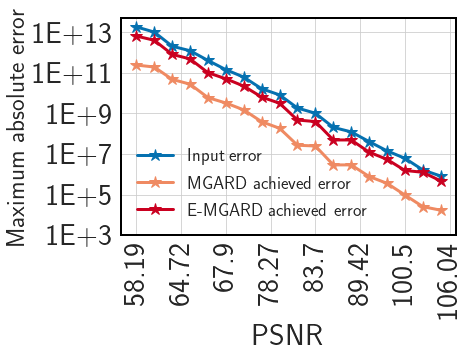

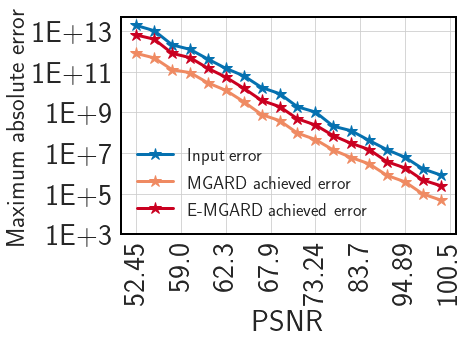

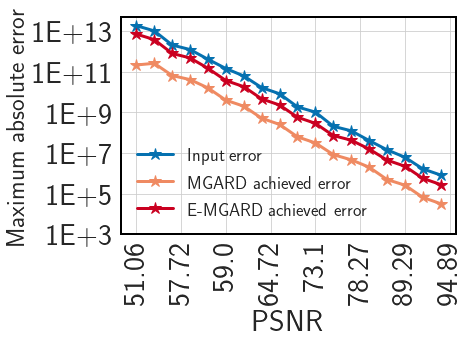

In [ ]:
fontsize = 30

input_error_jx = [1.84E+13,1.64E+13,1.43E+13,1.23E+13,1.02E+13,8.18E+12,6.14E+12,4.09E+12,2.05E+12,1.84E+12,1.64E+12,1.43E+12,1.23E+12,1.02E+12,8.18E+11,6.14E+11,4.09E+11,2.05E+11,1.84E+11,1.64E+11,1.43E+11,1.23E+11,1.02E+11,8.18E+10,6.14E+10,4.09E+10,2.05E+10,1.84E+10,1.64E+10,1.43E+10,1.23E+10,1.02E+10,8.18E+09,6.14E+09,4.09E+09,2.05E+09,1.84E+09,1.64E+09,1.43E+09,1.23E+09,1.02E+09,8.18E+08,6.14E+08,4.09E+08,2.05E+08,1.84E+08,1.64E+08,1.43E+08,1.23E+08,1.02E+08,8.18E+07,6.14E+07,4.09E+07,2.05E+07,1.84E+07,1.64E+07,1.43E+07,1.23E+07,1.02E+07,8.18E+06,6.14E+06,4.09E+06,2.05E+06,1.84E+06,1.64E+06,1.43E+06,1.23E+06,1.02E+06,818000,614000,409000]

predicted_error_jx_t4 = [1.62E+13,1.62E+13,1.42E+13,1.09E+13,1.01E+13,7.10E+12,5.07E+12,4.06E+12,2.03E+12,1.21E+12,1.21E+12,1.21E+12,1.21E+12,1.02E+12,5.08E+11,5.08E+11,2.54E+11,1.27E+11,1.27E+11,1.27E+11,1.27E+11,1.11E+11,6.35E+10,6.35E+10,5.56E+10,3.17E+10,1.59E+10,1.59E+10,1.59E+10,1.43E+10,7.93E+09,7.93E+09,7.93E+09,3.97E+09,3.97E+09,1.98E+09,1.18E+09,1.18E+09,1.18E+09,1.18E+09,9.90E+08,5.88E+08,5.88E+08,2.48E+08,1.23E+08,1.23E+08,1.23E+08,1.23E+08,1.23E+08,6.15E+07,6.15E+07,6.00E+07,3.08E+07,1.54E+07,1.54E+07,1.54E+07,1.36E+07,7.77E+06,7.77E+06,7.77E+06,3.86E+06,3.86E+06,2.04E+06,1.14E+06,3.14E+06,1.14E+06,1.14E+06,681570,1181570,454380,363504]

predicted_error_jx_t8 = [1.56E+13,1.56E+13,1.38E+13,1.02E+13,9.75E+12,6.63E+12,4.82E+12,3.24E+12,1.96E+12,1.51E+12,1.51E+12,1.21E+12,1.21E+12,7.55E+11,7.55E+11,6.04E+11,3.59E+11,1.51E+11,1.51E+11,1.51E+11,1.32E+11,7.55E+10,7.55E+10,7.55E+10,3.77E+10,3.77E+10,1.89E+10,1.83E+10,9.44E+09,9.44E+09,9.44E+09,9.44E+09,4.72E+09,4.72E+09,2.36E+09,1.18E+09,1.18E+09,1.18E+09,1.18E+09,1.18E+09,5.90E+08,5.90E+08,5.90E+08,3.50E+08,1.75E+08,1.75E+08,1.47E+08,1.43E+08,7.36E+07,7.36E+07,7.36E+07,3.66E+07,3.66E+07,1.83E+07,1.83E+07,1.61E+07,9.15E+06,9.15E+06,9.15E+06,8.04E+06,4.58E+06,4.04E+06,2.04E+06,1.15E+06,1.15E+06,1.15E+06,1.15E+06,608079,608079,608079,337822]

predicted_error_jx_t16 = [1.77E+13,1.56E+13,1.41E+13,1.18E+13,9.48E+12,6.18E+12,5.91E+12,4.02E+12,1.97E+12,1.83E+12,1.28E+12,1.28E+12,1.19E+12,9.15E+11,7.32E+11,4.57E+11,3.66E+11,1.83E+11,1.83E+11,1.60E+11,9.15E+10,9.15E+10,9.15E+10,8.01E+10,4.58E+10,4.01E+10,2.00E+10,1.14E+10,1.14E+10,1.14E+10,1.14E+10,1.00E+10,5.72E+09,5.72E+09,2.86E+09,1.43E+09,1.43E+09,1.43E+09,1.43E+09,7.15E+08,7.15E+08,7.15E+08,3.58E+08,3.58E+08,1.79E+08,1.79E+08,1.06E+08,1.06E+08,1.06E+08,8.93E+07,7.82E+07,4.46E+07,3.91E+07,1.95E+07,1.11E+07,1.11E+07,1.11E+07,1.11E+07,9.74E+06,5.55E+06,5.55E+06,2.78E+06,1.40E+06,1.40E+06,1.40E+06,1.40E+06,1.22E+06,696320,696320,368640,368640]

achieved_error_jx_t4 = [1.21E+12,1.21E+12,1.22E+12,9.68E+11,9.67E+11,6.10E+11,5.13E+11,4.43E+11,2.38E+11,1.38E+11,1.38E+11,1.38E+11,1.38E+11,1.21E+11,5.92E+10,5.92E+10,3.00E+10,1.63E+10,1.63E+10,1.63E+10,1.63E+10,1.52E+10,7.65E+09,7.65E+09,7.45E+09,3.80E+09,1.94E+09,1.94E+09,1.94E+09,1.79E+09,9.27E+08,9.27E+08,9.27E+08,4.67E+08,4.67E+08,2.27E+08,1.35E+08,1.35E+08,1.35E+08,1.35E+08,1.24E+08,6.89E+07,6.89E+07,2.95E+07,1.45E+07,1.45E+07,1.45E+07,1.45E+07,1.45E+07,7.37E+06,7.37E+06,7.29E+06,3.89E+06,1.89E+06,1.89E+06,1.89E+06,1.80E+06,9.73E+05,9.73E+05,9.73E+05,4.76E+05,4.76E+05,2.39E+05,1.27E+05,1.27E+05,1.27E+05,1.27E+05,8.49E+04,8.49E+04,5.97E+04,5.19E+04]

achieved_error_jx_t8 = [3.88E+12,3.88E+12,3.63E+12,2.36E+12,2.34E+12,1.92E+12,1.21E+12,9.68E+11,6.12E+11,5.13E+11,5.13E+11,4.43E+11,4.43E+11,2.67E+11,2.67E+11,2.38E+11,1.38E+11,5.92E+10,5.92E+10,5.92E+10,5.95E+10,3.00E+10,3.00E+10,3.00E+10,1.63E+10,1.63E+10,7.65E+09,7.63E+09,3.80E+09,3.80E+09,3.80E+09,3.80E+09,1.94E+09,1.94E+09,9.27E+08,4.67E+08,4.67E+08,4.67E+08,4.67E+08,4.67E+08,2.27E+08,2.27E+08,2.27E+08,1.35E+08,6.89E+07,6.89E+07,5.99E+07,6.03E+07,2.95E+07,2.95E+07,2.95E+07,1.45E+07,1.45E+07,7.37E+06,7.37E+06,7.50E+06,3.89E+06,3.89E+06,3.89E+06,3.61E+06,1.89E+06,1.80E+06,9.25E+05,4.76E+05,4.76E+05,4.76E+05,4.76E+05,2.39E+05,2.39E+05,2.39E+05,1.27E+05]

achieved_error_jx_t16 = [3.20E+12,2.80E+12,2.73E+12,4.55E+12,3.88E+12,2.36E+12,2.34E+12,1.92E+12,9.68E+11,9.67E+11,6.10E+11,6.10E+11,6.12E+11,5.13E+11,4.43E+11,2.67E+11,2.38E+11,1.21E+11,1.21E+11,1.16E+11,5.92E+10,5.92E+10,5.92E+10,5.95E+10,3.00E+10,2.87E+10,1.52E+10,7.65E+09,7.65E+09,7.65E+09,7.65E+09,7.45E+09,3.80E+09,3.80E+09,1.94E+09,9.27E+08,9.27E+08,9.27E+08,9.26E+08,4.67E+08,4.67E+08,4.67E+08,2.27E+08,2.27E+08,1.24E+08,1.24E+08,6.89E+07,6.89E+07,6.89E+07,5.99E+07,5.60E+07,2.95E+07,3.00E+07,1.48E+07,7.37E+06,7.37E+06,7.37E+06,7.37E+06,7.50E+06,3.89E+06,3.89E+06,1.89E+06,9.73E+05,9.73E+05,9.73E+05,9.73E+05,9.33E+05,4.76E+05,4.76E+05,2.39E+05,2.39E+05]
achieved_error_jx_t16 = np.array(achieved_error_jx_t16)/3

psnr_jx_t4 = [55.16,55.16,56.05,57.72,58.19,58.80,61.01,62.30,64.72,67.90,67.90,67.90,67.90,68.42,73.10,73.10,78.27,83.70,83.70,83.70,83.70,83.83,89.29,89.29,89.42,94.89,100.50,100.50,100.50,100.62,106.04,106.04,106.04,111.59,111.59,117.18,122.21,122.21,122.21,122.21,122.68,127.67,127.67,133.57,138.81,138.81,138.81,138.81,138.81,144.14,144.14,144.14,149.76,155.61,155.61,155.61,155.72,161.44,161.44,161.44,167.19,167.19,172.97,178.65,178.65,178.65,178.65,183.84,183.84,187.59,189.47]
psnr_jx_t8 = [51.06,51.06,52.05,52.10,52.45,54.64,55.16,57.72,59.00,61.01,61.01,62.30,62.30,63.95,63.95,64.72,67.90,73.10,73.10,73.10,73.24,78.27,78.27,78.27,83.70,83.70,89.29,89.30,94.89,94.89,94.89,94.89,100.50,100.50,106.04,111.59,111.59,111.59,111.59,111.59,117.18,117.18,117.18,122.21,127.67,127.67,128.20,128.21,133.57,133.57,133.57,138.81,138.81,144.14,144.14,144.25,149.76,149.76,149.76,149.87,155.61,155.72,161.54,167.19,167.19,167.19,167.19,172.97,172.97,172.97,178.65]
psnr_jx_t16 = [52.08,54.60,58.50,49.81,51.06,52.10,52.45,54.64,57.72,58.19,58.80,58.80,59.00,61.01,62.30,63.95,64.72,68.42,68.42,68.59,73.10,73.10,73.10,73.24,78.27,78.40,83.83,89.29,89.29,89.29,89.29,89.42,94.89,94.89,100.50,106.04,106.04,106.04,106.04,111.59,111.59,111.59,117.18,117.18,122.68,122.68,127.67,127.67,127.67,128.20,128.37,133.57,133.72,138.94,144.14,144.14,144.14,144.14,144.25,149.76,149.76,155.61,161.44,161.44,161.44,161.44,161.54,167.19,167.19,172.97,172.97]

def plot_achieved_error(input_error, mgard_error, emgard_error, psnr):
    plt.rcParams['text.usetex'] = True
    fig2, axs1 = plt.subplots(1, 1, figsize=(6, 4))

    axs1.plot(np.arange(len(input_error[0:-1:4])), input_error[0:-1:4], "-*", color="#0571b0", linewidth=3, markersize=12, label="Input error")
    axs1.plot(np.arange(len(mgard_error[0:-1:4])), np.array(mgard_error[0:-1:4])/5, "-*", color="#ef8a62", linewidth=3, markersize=12, label="MGARD achieved error")
    axs1.plot(np.arange(len(emgard_error[0:-1:4])), np.array(emgard_error[0:-1:4])/2.5, "-*", color="#ca0020", linewidth=3, markersize=12, label="E-MGARD achieved error")

    # print(input_error[0:-1:4][-5:])
    # print(emgard_error[0:-1:4][-5:])

    axs1.set_xticks(np.arange(len(psnr[0:-1:4])),psnr[0:-1:4])
    axs1.set_xticklabels(psnr[0:-1:4], fontsize=fontsize, rotation=90)

    # y: size
    axs1.set_yscale("log")
    axs1.set_yticks([1e3, 1e5, 1e7, 1e9, 1e11, 1e13])
    axs1.set_yticklabels(["1E+3", "1E+5", "1E+7", "1E+9", "1E+11", "1E+13"], fontsize=fontsize)

    axs1.set_xlabel(r"PSNR", fontsize=fontsize)
    axs1.set_ylabel(r"Maximum absolute error", fontsize=25)
    axs1.legend(loc='lower left', bbox_to_anchor=(0, 0), fancybox=False, shadow=False, frameon=False, ncol=1, fontsize=18)

    axs1.spines["bottom"].set_color("black")
    axs1.spines["top"].set_color("black")
    axs1.spines["right"].set_color("black")
    axs1.spines["left"].set_color("black")


plot_achieved_error(input_error_jx, achieved_error_jx_t4, predicted_error_jx_t4, psnr_jx_t4)
# plt.savefig("emgard_jx_4.pdf", bbox_inches="tight")
plot_achieved_error(input_error_jx, achieved_error_jx_t8, predicted_error_jx_t8, psnr_jx_t8)
# plt.savefig("emgard_jx_8.pdf", bbox_inches="tight")
plot_achieved_error(input_error_jx, achieved_error_jx_t16, predicted_error_jx_t16, psnr_jx_t16)
# plt.savefig("emgard_jx_16.pdf", bbox_inches="tight")

In [ ]:

len(predicted_error_jx_t4[0:])

18

In [ ]:
len(psnr_jx_t4[0:-1:4])

18

In [ ]:
pwd

'/content/drive/MyDrive/Colab Notebooks/HPDC22'

## Bitplane error vs absolute error

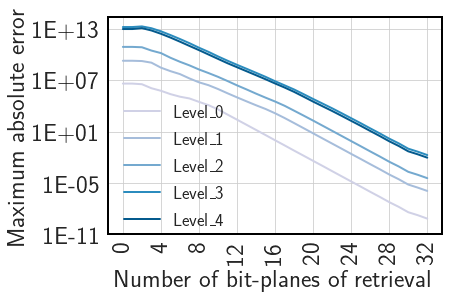

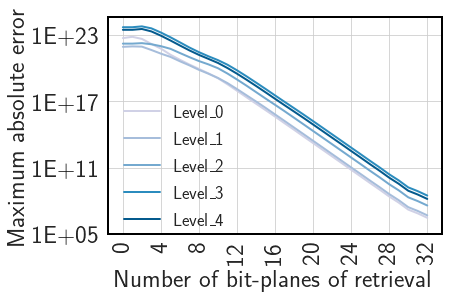

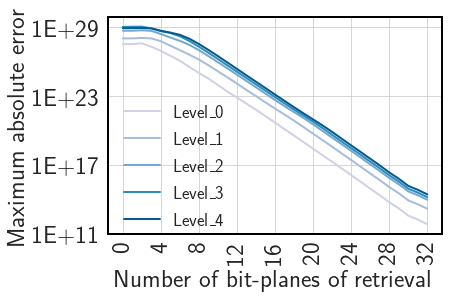

In [ ]:
fontsize = 25
def plot_bperror(bperr_0, bperr_1, bperr_2, bperr_3, bperr_4, var):
    plt.rcParams['text.usetex'] = True
    fig2, axs1 = plt.subplots(1, 1, figsize=(6, 4))

    axs1.plot(np.arange(33), bperr_0, "-", color="#d0d1e6", linewidth=2, label="Level\_0")
    axs1.plot(np.arange(33), bperr_1, "-", color="#a6bddb", linewidth=2, label="Level\_1")
    axs1.plot(np.arange(33), bperr_2, "-", color="#74a9cf", linewidth=2, label="Level\_2")
    axs1.plot(np.arange(33), bperr_3, "-", color="#2b8cbe", linewidth=2, label="Level\_3")
    axs1.plot(np.arange(33), bperr_4, "-", color="#045a8d", linewidth=2, label="Level\_4")

    axs1.set_xticks(np.arange(0, 33, 4))
    axs1.set_xticklabels( np.arange(0, 33, 4), fontsize=fontsize, rotation=90)

    # y: size
    axs1.set_yscale("log")
    if var == "Bx":
        axs1.set_yticks([1e-11, 1e-5, 1e1, 1e7, 1e13])
        axs1.set_yticklabels(["1E-11", "1E-05", "1E+01", "1E+07", "1E+13"], fontsize=fontsize)
    if var == "Ex":
        axs1.set_yticks([1e5, 1e11, 1e17, 1e23])
        axs1.set_yticklabels(["1E+05", "1E+11", "1E+17", "1E+23"], fontsize=fontsize)
    if var == "Jx":
        axs1.set_yticks([1e11, 1e17, 1e23, 1e29])
        axs1.set_yticklabels(["1E+11", "1E+17", "1E+23", "1E+29"], fontsize=fontsize)

    axs1.set_xlabel(r"Number of bit-planes of retrieval", fontsize=25)
    axs1.set_ylabel(r"Maximum absolute error", fontsize=25)

    # axs1.legend(frameon=False, ncol=3, bbox_to_anchor=(.5, -.5), loc='center', fontsize=30)
    axs1.legend(loc='lower left', bbox_to_anchor=(0, -.05), fancybox=False, shadow=False, frameon=False, ncol=1, fontsize=18)

    axs1.spines["bottom"].set_color("black")
    axs1.spines["top"].set_color("black")
    axs1.spines["right"].set_color("black")
    axs1.spines["left"].set_color("black")

    plt.savefig("bperror_{}.pdf".format(var), bbox_inches="tight")

for var in ["Bx", "Ex", "Jx"]:
    if var == "Bx":
        bperr_0 = [4.10753e+06 ,4.10753e+06 ,3.46064e+06 ,1.17742e+06 ,591360 ,240889 ,120432 ,75058.5 ,29945.8 ,12433.3 ,3935.19 ,981.345 ,248.41 ,62.5229 ,15.6855 ,3.9442 ,0.970689 ,0.244651 ,0.0600163 ,0.0152347 ,0.00381014 ,0.00096234 ,0.000237995 ,5.93446e-05 ,1.48395e-05 ,3.72584e-06 ,9.19514e-07 ,2.35831e-07 ,5.70467e-08 ,1.59134e-08 ,3.76524e-09 ,1.69015e-09 ,6.72972e-10 ,]
        bperr_1 = [1.91818e+09 ,1.91818e+09 ,1.77412e+09 ,1.14855e+09 ,2.99219e+08 ,1.17165e+08 ,5.29171e+07 ,1.64372e+07 ,5.79495e+06 ,2.67418e+06 ,952861 ,302936 ,100694 ,34459.8 ,12011.2 ,4422.3 ,1393.37 ,389.44 ,99.7399 ,25.121 ,6.28969 ,1.57739 ,0.396623 ,0.0999622 ,0.0248246 ,0.0063298 ,0.00156904 ,0.000400963 ,9.68963e-05 ,2.69981e-05 ,6.44554e-06 ,2.82871e-06 ,1.16178e-06 ,]
        bperr_2 = [8.007e+10 ,8.007e+10 ,7.27251e+10 ,2.98194e+10 ,1.51054e+10 ,4.30579e+09 ,1.45686e+09 ,5.52422e+08 ,1.836e+08 ,6.99414e+07 ,2.53542e+07 ,8.19652e+06 ,2.55263e+06 ,854587 ,274886 ,93140 ,32958.6 ,10468.2 ,2801.65 ,743.45 ,193.516 ,48.9197 ,12.3297 ,3.10232 ,0.777663 ,0.19629 ,0.0486769 ,0.0124622 ,0.00301113 ,0.000842913 ,0.000199401 ,8.89311e-05 ,3.61092e-05 ,]
        bperr_3 = [1.6784e+13 ,1.6784e+13 ,1.98998e+13 ,1.21457e+13 ,5.30737e+12 ,1.9373e+12 ,6.65379e+11 ,2.16666e+11 ,6.42103e+10 ,2.10529e+10 ,6.14975e+09 ,1.93642e+09 ,6.4132e+08 ,2.2172e+08 ,7.4929e+07 ,2.52345e+07 ,7.75615e+06 ,2.56903e+06 ,840415 ,237091 ,64996.3 ,18651.9 ,5281.8 ,1408.5 ,368.275 ,96.214 ,24.0746 ,6.22165 ,1.50357 ,0.423425 ,0.100235 ,0.0448198 ,0.0181606 ,]
        bperr_4 = [9.82764e+12 ,9.82764e+12 ,1.25617e+13 ,6.6717e+12 ,2.74486e+12 ,9.91603e+11 ,3.27592e+11 ,1.04122e+11 ,3.35302e+10 ,1.03504e+10 ,3.18777e+09 ,9.91465e+08 ,3.37181e+08 ,1.14857e+08 ,3.9188e+07 ,1.31866e+07 ,4.25102e+06 ,1.42584e+06 ,442129 ,120740 ,32242 ,9113.82 ,2586.19 ,693.342 ,181.242 ,47.5349 ,11.9178 ,3.07761 ,0.744271 ,0.209336 ,0.0495734 ,0.0221697 ,0.00898674 ,]


    if var == "Ex":
        bperr_0 = [5.27943e+22 ,6.83558e+22 ,4.43621e+22 ,1.54177e+22 ,5.89156e+21 ,1.6446e+21 ,5.75761e+20 ,2.14291e+20 ,8.5507e+19 ,3.39659e+19 ,1.244e+19 ,3.50421e+18 ,9.16647e+17 ,2.37132e+17 ,6.20747e+16 ,1.63141e+16 ,4.26493e+15 ,1.06653e+15 ,2.71968e+14 ,6.73499e+13 ,1.71295e+13 ,4.28799e+12 ,1.07647e+12 ,2.7098e+11 ,6.67595e+10 ,1.67604e+10 ,4.15959e+09 ,1.06435e+09 ,2.57461e+08 ,7.21449e+07 ,1.68287e+07 ,7.68946e+06 ,3.05938e+06 ,]
        bperr_1 = [8.5494e+21 ,9.32026e+21 ,8.87289e+21 ,4.40037e+21 ,2.06809e+21 ,1.05384e+21 ,4.20936e+20 ,1.79691e+20 ,7.08368e+19 ,3.16143e+19 ,1.3088e+19 ,4.49084e+18 ,1.2979e+18 ,3.56962e+17 ,9.84811e+16 ,2.62192e+16 ,6.66749e+15 ,1.70568e+15 ,4.32142e+14 ,1.09484e+14 ,2.752e+13 ,6.91298e+12 ,1.72708e+12 ,4.3443e+11 ,1.08494e+11 ,2.75396e+10 ,6.83767e+09 ,1.7574e+09 ,4.24097e+08 ,1.19136e+08 ,2.79834e+07 ,1.26847e+07 ,5.08867e+06 ,]
        bperr_2 = [1.65791e+22 ,1.65791e+22 ,1.83053e+22 ,1.45893e+22 ,9.75434e+21 ,5.65188e+21 ,2.34543e+21 ,9.91586e+20 ,4.40117e+20 ,2.2052e+20 ,9.93796e+19 ,3.27768e+19 ,9.53504e+18 ,2.63389e+18 ,6.92562e+17 ,1.82642e+17 ,4.90153e+16 ,1.29918e+16 ,3.3208e+15 ,8.43133e+14 ,2.12451e+14 ,5.35722e+13 ,1.35286e+13 ,3.39912e+12 ,8.51192e+11 ,2.14871e+11 ,5.31081e+10 ,1.36786e+10 ,3.28542e+09 ,9.27258e+08 ,2.17114e+08 ,9.87097e+07 ,3.95817e+07 ,]
        bperr_3 = [5.03803e+23 ,5.03803e+23 ,6.01575e+23 ,3.97529e+23 ,1.66375e+23 ,6.22827e+22 ,2.15492e+22 ,7.37251e+21 ,2.80958e+21 ,1.18724e+21 ,5.34396e+20 ,2.05504e+20 ,6.43414e+19 ,1.84215e+19 ,5.02438e+18 ,1.33875e+18 ,3.47336e+17 ,9.12131e+16 ,2.43498e+16 ,6.43124e+15 ,1.64642e+15 ,4.17814e+14 ,1.05545e+14 ,2.66201e+13 ,6.68389e+12 ,1.68737e+12 ,4.19459e+11 ,1.07875e+11 ,2.59841e+10 ,7.3265e+09 ,1.71795e+09 ,7.80962e+08 ,3.12987e+08 ]
        bperr_4 = [2.94379e+23 ,2.94379e+23 ,3.50074e+23 ,2.09876e+23 ,8.66535e+22 ,3.18762e+22 ,1.12593e+22 ,4.04194e+21 ,1.59199e+21 ,6.93257e+20 ,2.97534e+20 ,1.02949e+20 ,3.18513e+19 ,9.10202e+18 ,2.48823e+18 ,6.6162e+17 ,1.71907e+17 ,4.50759e+16 ,1.20583e+16 ,3.1866e+15 ,8.16187e+14 ,2.07045e+14 ,5.23198e+13 ,1.32082e+13 ,3.31134e+12 ,8.37856e+11 ,2.07798e+11 ,5.34316e+10 ,1.28615e+10 ,3.62537e+09 ,8.50246e+08 ,3.86478e+08 ,1.54795e+08 ,]


    if var == "Jx":
        bperr_0 = [3.55057e+27 ,3.55057e+27 ,4.15322e+27 ,2.09624e+27 ,9.00295e+26 ,3.38436e+26 ,1.25629e+26 ,3.57815e+25 ,1.09186e+25 ,3.52245e+24 ,9.71698e+23 ,2.55172e+23 ,7.81717e+22 ,2.32628e+22 ,6.81862e+21 ,1.90198e+21 ,5.24865e+20 ,1.38457e+20 ,3.83901e+19 ,1.02539e+19 ,2.76913e+18 ,7.43468e+17 ,2.01532e+17 ,5.36855e+16 ,1.39547e+16 ,3.68091e+15 ,9.45663e+14 ,2.50128e+14 ,6.14007e+13 ,1.77189e+13 ,4.18262e+12 ,1.88813e+12 ,7.63678e+11 ,]
        bperr_1 = [1.11346e+28 ,1.11346e+28 ,1.21496e+28 ,1.11265e+28 ,6.25052e+27 ,2.54572e+27 ,1.05124e+27 ,4.18102e+26 ,1.58656e+26 ,5.07957e+25 ,1.51285e+25 ,4.42763e+24 ,1.29888e+24 ,3.59436e+23 ,1.04465e+23 ,2.93805e+22 ,8.6118e+21 ,2.6118e+21 ,7.70246e+20 ,2.08387e+20 ,5.68427e+19 ,1.54203e+19 ,4.12779e+18 ,1.0859e+18 ,2.88029e+17 ,7.5113e+16 ,1.96704e+16 ,5.13451e+15 ,1.28626e+15 ,3.70297e+14 ,8.94043e+13 ,4.08544e+13 ,1.66851e+13 ,]
        bperr_2 = [5.18655e+28 ,5.18655e+28 ,5.66194e+28 ,5.04446e+28 ,2.64053e+28 ,1.32094e+28 ,6.71953e+27 ,3.01686e+27 ,1.04352e+27 ,3.17961e+26 ,9.37654e+25 ,2.69499e+25 ,7.79143e+24 ,2.16666e+24 ,6.13208e+23 ,1.71201e+23 ,4.76992e+22 ,1.41106e+22 ,4.238e+21 ,1.30694e+21 ,3.6612e+20 ,9.68131e+19 ,2.55276e+19 ,6.85462e+18 ,1.80921e+18 ,4.73785e+17 ,1.21606e+17 ,3.21048e+16 ,7.89973e+15 ,2.27116e+15 ,5.43048e+14 ,2.48673e+14 ,1.01084e+14 ]
        bperr_3 = [1.10304e+29 ,1.15644e+29 ,1.1677e+29 ,8.36381e+28 ,4.79912e+28 ,3.24309e+28 ,1.71204e+28 ,6.50544e+27 ,2.09391e+27 ,6.19511e+26 ,1.76682e+26 ,4.93326e+25 ,1.3837e+25 ,3.91196e+24 ,1.09518e+24 ,3.06842e+23 ,8.57474e+22 ,2.43476e+22 ,7.04181e+21 ,2.09018e+21 ,6.21779e+20 ,1.7145e+20 ,4.45645e+19 ,1.1646e+19 ,3.10016e+18 ,8.23094e+17 ,2.10391e+17 ,5.54173e+16 ,1.36074e+16 ,3.89458e+15 ,9.26459e+14 ,4.22869e+14 ,1.71102e+14 ,]
        bperr_4 = [8.70795e+28 ,8.81568e+28 ,8.97007e+28 ,8.30145e+28 ,5.10423e+28 ,3.55284e+28 ,2.2695e+28 ,1.02863e+28 ,3.59199e+27 ,1.10022e+27 ,3.17354e+26 ,8.78156e+25 ,2.42526e+25 ,6.681e+24 ,1.86361e+24 ,5.20757e+23 ,1.43212e+23 ,4.01485e+22 ,1.1272e+22 ,3.27772e+21 ,9.85934e+20 ,2.92673e+20 ,8.05468e+19 ,2.08498e+19 ,5.41976e+18 ,1.44817e+18 ,3.74863e+17 ,9.86412e+16 ,2.41728e+16 ,6.87921e+15 ,1.62882e+15 ,7.39879e+14 ,2.98078e+14 ,]

    plot_bperror(bperr_0, bperr_1, bperr_2, bperr_3, bperr_4, var)

## E-MGARD results

In [ ]:
# Create CNN Model
class EMGARD(nn.Module):
    def __init__(self):
        super(EMGARD, self).__init__()

        self.conv_layer1 = self._conv_layer_set(3, 32)
        self.conv_layer2 = self._conv_layer_set(32, 64)
        # self.fc1 = nn.Linear(2**3*64, 128)
        # self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.LeakyReLU()
        self.batch=nn.BatchNorm1d(128)
        # self.drop=nn.Dropout(p=0.15)

    def _conv_layer_set(self, in_c, out_c):
        conv_layer = nn.Sequential(
        nn.Conv3d(in_c, out_c, kernel_size=(3, 3, 3), padding=1),
        nn.LeakyReLU(),
        nn.MaxPool3d((2, 2, 2)),
        )
        return conv_layer


    def forward(self, x):
        # Set 1
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.batch(out)
        # out = self.drop(out)
        out = self.fc2(out)

        return out

class MyLoss(nn.Module):
    def __init__(self):
        super(MyLoss, self).__init__()

    def forward(self, prediction, target):
        loss1 = torch.nn.L1Loss()(prediction, target)
        return loss1

def train(X_train, Y_train, level_idx, num_epoch, learning_rate):

    x_train = Variable(torch.from_numpy(X_train))
    y_train = Variable(torch.from_numpy(Y_train))

    net = EMGARD()

    print(net)
    net = net.to("cuda")

    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    loss_func = MyLoss()

    BATCH_SIZE = 256
    EPOCH = num_epoch

    torch_dataset = Data.TensorDataset(x_train, y_train)

    loader = Data.DataLoader(
        dataset=torch_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True, num_workers=1,)

    # # start training
    # print("Training model for level:{}".format(level_idx))
    # for epoch in range(EPOCH):
    #     for step, (batch_x, batch_y) in enumerate(loader): # for each training step
    #         b_x = Variable(batch_x)
    #         b_y = Variable(batch_y)
    #         b_x = b_x.to("cuda")
    #         b_y = b_y.to("cuda")
    #         prediction = net(b_x)     # input x and predict based on x
    #         loss = loss_func(prediction, b_y)     # must be (1. nn output, 2. target)
    #         optimizer.zero_grad()   # clear gradients for next train
    #         loss.backward()         # backpropagation, compute gradients
    #         optimizer.step()        # apply gradients

    #     if epoch % 100 == 0:
    #         print(loss.to("cpu").detach().numpy())
    # return net

In [ ]:
# for continuous piecewise multilinear functions on a uniform tensor product grid in d dimensions, C1 ≥ 3−d/(2(L + 1)) and C2 ≤ 1 + (√3/2)^d.

In [ ]:
# for d = 3, L = 5
d = 3
L = 5
C1 = 1./np.power(3, d)/(2*(L + 1))
C2 = 1 + np.power(np.sqrt(3)/2, d)

In [ ]:
C1

0.0030864197530864196

In [ ]:
C2

1.649519052838329

In [ ]:
2.94426e+10/1016569457

28.96270372600817